In [1065]:
import os
from os.path import join, basename
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import setp
import matplotlib.colors as mcolors
import cv2
from time import time

from data import bbox_utils as box
from statistics import evaluate_distance_cutoffs

In [343]:
def mask_color_img(img, mask, color=[255, 0, 0], alpha=0.3):
    out = img.copy()
    img_layer = img.copy()
    img_layer[mask.astype(np.bool)] = color
    out = cv2.addWeighted(img_layer, alpha, out, 1 - alpha, 0, out)
    return(out)

In [276]:
def simple_segement(image):
    
    kernel = np.ones(9).reshape((3, 3))

    edges = cv2.Canny(image, 15, 50)    
    dilation = cv2.dilate(edges, kernel, iterations = 2)
    opening = cv2.morphologyEx(dilation, cv2.MORPH_OPEN, kernel, iterations = 2)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    erosion = cv2.erode(closing, kernel, iterations = 1)
    
    return erosion

In [277]:
def get_confluency(mask):
    bool_mask = mask.astype(np.bool)
    total = len(bool_mask.flatten())
    foreground = np.sum(bool_mask)
    return foreground/total

In [278]:
def min_max_norm(x, new_max=1):   
    x_np = np.array(x)
    x_max = np.max(x_np)
    x_min = np.min(x_np)
    x_np = x_np - x_min
    max_diff = x_max - x_min
    return x_np / max_diff

In [279]:
def arbitary_min_max_norm(x, tmax, tmin=0):
    x_np = np.array(x)
    rmin = np.min(x_np)
    rmax = np.max(x_np)
    r_diff = rmax - rmin
    t_diff = tmax - tmin
    x_np = x_np - rmin
    x_np = x_np / r_diff
    return x_np * t_diff + tmin

In [318]:
def get_image_stats(path, normalize=True, image_type=".png"):
    """
    Returns image confluency and standard deviation for every image in path.
    
    :param path: Path to image directory
    :param normalize: Normalize images to confluence min/max
    :param image_type: Type of images in path
    :return:
    """
    
    confluencys = []
    stds = []

    for img_path in glob(join(path, f"*{image_type}")):
        
        if "20200203_3T3_Hoechst_Pos3" in dir_name and basename(img_path) == "Stack0057.png":
            print("Skipped:", join(image_dir, img_path))
            continue
        
        image = cv2.imread(img_path)

        stds.append(np.std(image))

        segmented = simple_segement(image).astype(np.bool)
        confluency = np.round(get_confluency(segmented), 4)*100
        confluencys.append(confluency)
    
    confluencys = np.array(confluencys)
    stds = np.array(stds)
    
    if len(confluencys) == 0 or len(stds) == 0:
        return confluencys, stds

    if normalize:
        conf_max = np.max(confluencys)
        conf_min = np.min(confluencys)
        confluencys = arbitary_min_max_norm(confluencys, conf_max, conf_min)
        stds = arbitary_min_max_norm(stds, conf_max, conf_min)
    
    return confluencys, stds

In [777]:
def write_text_on_image(image, text, position, size=1, color=(255,255,255), thicknes=3):
    """
    """
    return cv2.putText(image, text, position, cv2.FONT_HERSHEY_SIMPLEX, size, color, thicknes, cv2.LINE_AA) 

In [311]:
BASE_DIRS = glob("D:\\Nabil_object_detection\\train\\data\\*")
BASE_DIRS = [join(d, "10x") for d in BASE_DIRS]
BASE_DIRS.append("D:\\Nabil_object_detection\\val\\20200204_NRK_Hoechst_Pos7\\10x")

In [776]:
path = "D:\\Nabil_object_detection\\val\\20200204_NRK_Hoechst_Pos7\\10x"
out_path = "C:\\Users\\N.Jabareen\\presentations\\simple_conflunce_prediction"
images = tqdm(glob(join(path, "*.png")))
for i, image_path in enumerate(images):
    image = cv2.imread(image_path)
    segmented = simple_segement(image)
    masked = mask_color_img(image, segmented)
    confluence = get_confluency(segmented)*100
    masked = cv2.putText(masked, f"Confluence: {confluence:.2f}%", (50, 100), cv2.FONT_HERSHEY_SIMPLEX,  
                   3, (255,255,255), 7, cv2.LINE_AA) 
    masked = cv2.putText(masked, f"Frame: {i}", (50, 900), cv2.FONT_HERSHEY_SIMPLEX,  
                   2, (255,255,255), 7, cv2.LINE_AA) 
    
#     plt.imshow(masked)
#     plt.show()    
    cv2.imwrite(join(out_path, f"image_{i}.png"), masked)



  0%|                                                                                                                                                                                   | 0/75 [00:00<?, ?it/s]

  3%|████▌                                                                                                                                                                      | 2/75 [00:00<00:04, 17.28it/s]

  5%|█████████                                                                                                                                                                  | 4/75 [00:00<00:04, 17.42it/s]

  8%|█████████████▋                                                                                                                                                             | 6/75 [00:00<00:03, 17.50it/s]

 11%|██████████████████▏                                                                                                                                          

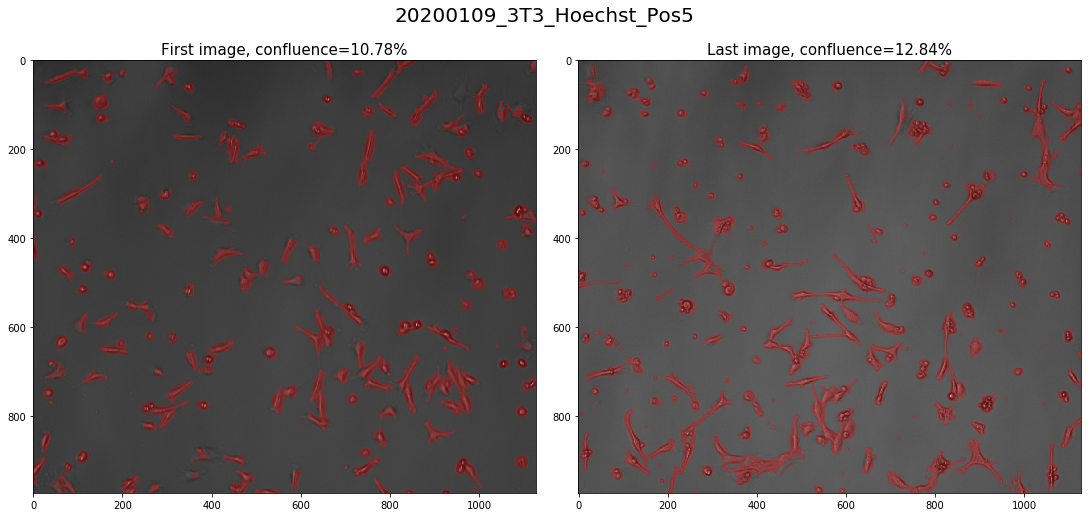

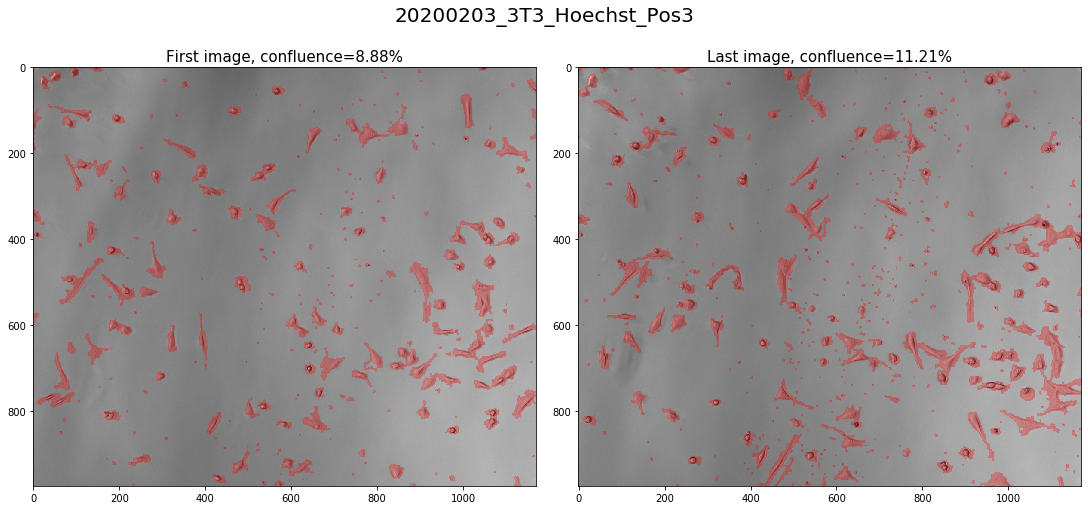

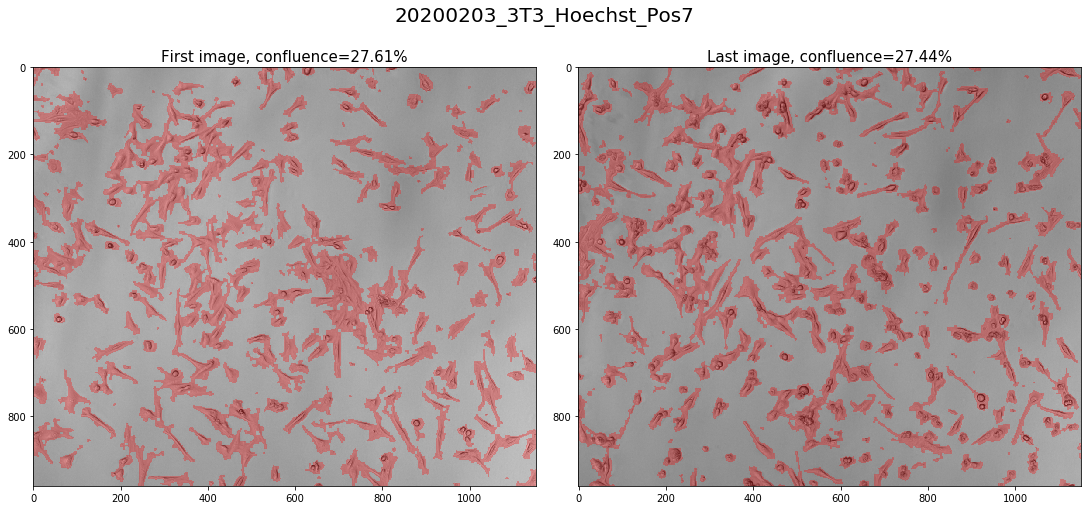

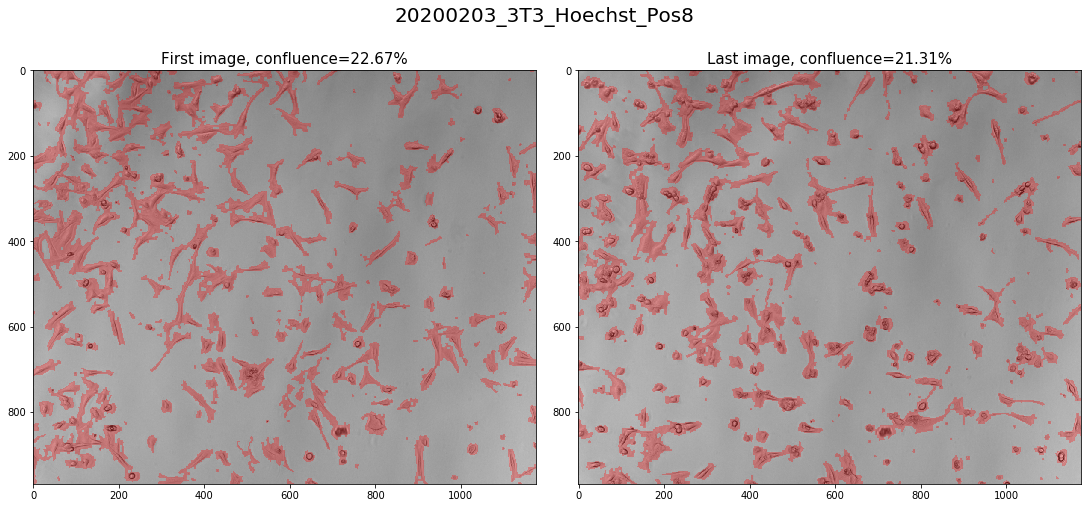

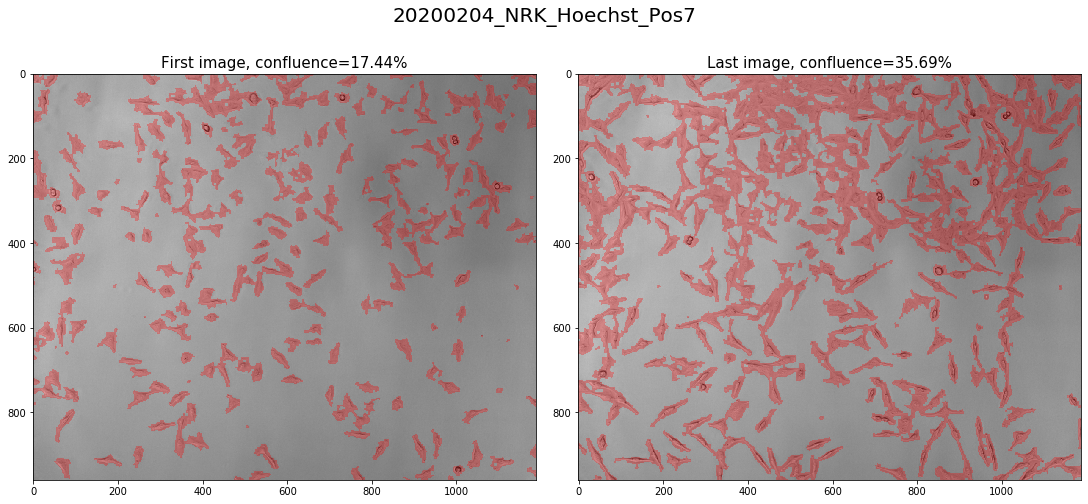

In [360]:
for image_dir in BASE_DIRS:
    image_paths = glob(join(image_dir, "*.png"))
    
    first_image, last_image = cv2.imread(image_paths[0]), cv2.imread(image_paths[-1])
    first_segments, last_segments = simple_segement(first_image), simple_segement(last_image)
    first_masked, last_masked = mask_color_img(first_image, first_segments), mask_color_img(last_image, last_segments)
    
    fist_conf, last_conf = get_confluency(first_segments)*100, get_confluency(last_segments)*100
    
    dir_name = image_dir.split("\\")[-2]
    
    fig, axs = plt.subplots(1, 2, constrained_layout=True)
    fig.suptitle(f"{dir_name}", fontsize=20, y=0.75)
    fig.set_size_inches((15,15))
    
    axs[0].set_title(f"First image, confluence={fist_conf:.2f}%", fontsize=15)
    axs[0].imshow(first_masked, cmap="gray")
    axs[1].set_title(f"Last image, confluence={last_conf:.2f}%", fontsize=15)
    axs[1].imshow(last_masked, cmap="gray")
    
    fig.set_tight_layout(False)
    plt.show()

In [729]:
confluencys = {}
stds = {}
for image_dir in BASE_DIRS:
    
    dir_name = image_dir.split("\\")[-2]
    
    confl, std = get_image_stats(image_dir, normalize=False)
    
    confluencys[dir_name] = confl
    stds[dir_name] = std
    
#     max_measure = max(max(confl), max(stds))
   
#     plt.figure(figsize=(12,6))
#     plt.title(f"{dir_name}", fontsize=20)
#     plt.plot(confl, label="Confluency", linewidth=5)
#     plt.plot(stds, label="Normalized Standard deviation")
#     plt.xlabel("Image", fontsize=15)
#     plt.ylabel("Confluency", fontsize=15) 
#     plt.xticks(fontsize=10) 
#     plt.yticks(np.linspace(0, max_measure, num=5), fontsize=10) 
#     plt.legend(fontsize=15, loc="lower right")
#     plt.show()

Skipped: D:\Nabil_object_detection\train\data\20200203_3T3_Hoechst_Pos3\10x\Stack0057.png


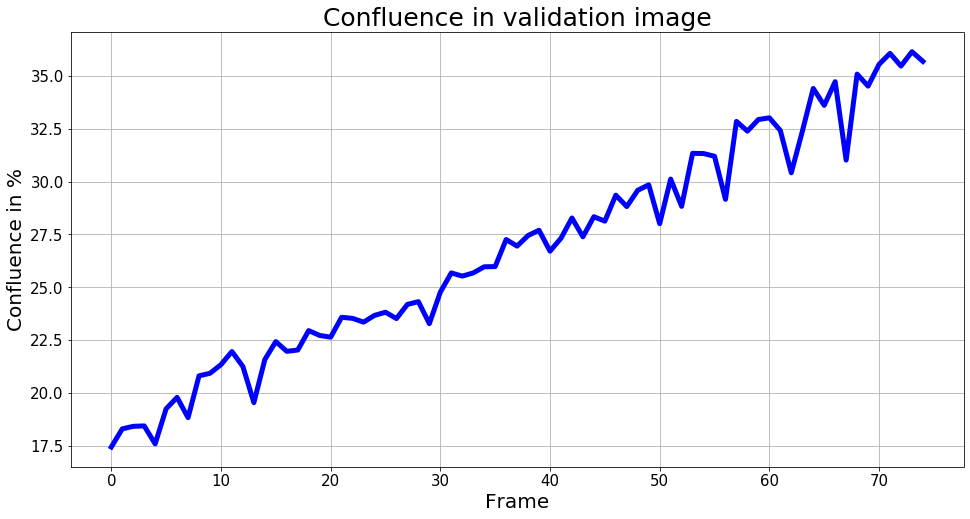

In [746]:
plt.figure(figsize=(16,8))
plt.title("Confluence in validation image", fontsize=25)
plt.plot(confluencys["20200204_NRK_Hoechst_Pos7"], linewidth=5, color="blue")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Frame", fontsize=20)
plt.ylabel("Confluence in %", fontsize=20)
plt.grid()
plt.show()

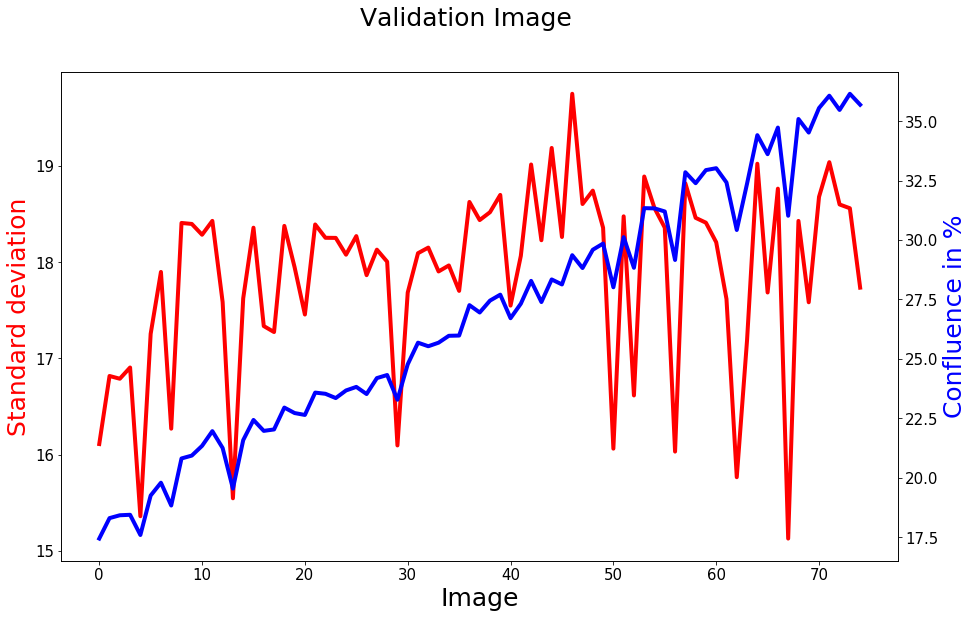

In [738]:
line_plot_two_axis(stds["20200204_NRK_Hoechst_Pos7"], confluencys["20200204_NRK_Hoechst_Pos7"], "Validation Image", "Standard deviation", "Confluence in %")

Text(0, 0.5, 'Confluence in %')

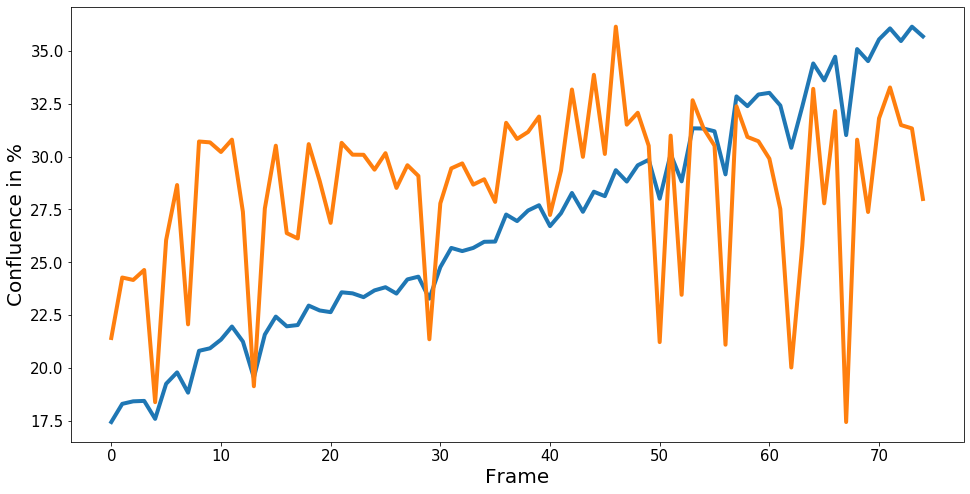

In [728]:
plt.figure(figsize=(16, 8))
plt.plot(confluencys["20200204_NRK_Hoechst_Pos7"], linewidth=4)
plt.plot(stds["20200204_NRK_Hoechst_Pos7"], linewidth=4)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Frame", fontsize=20)
plt.ylabel("Confluence in %", fontsize=20)

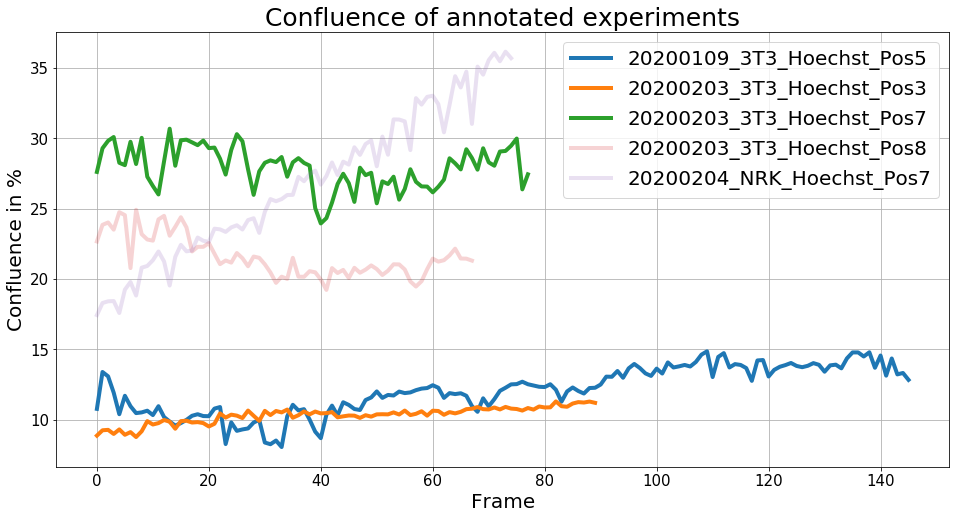

In [725]:
plt.figure(figsize=(16,8))
plt.title("Confluence of annotated experiments", fontsize=25)
for key, item in confluencys.items():
    alpha = 1
    if "Pos8" in key or "NRK" in key:
        alpha = 0.2
    plt.plot(item, label=key, linewidth=4, alpha=alpha)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Frame", fontsize=20)
plt.ylabel("Confluence in %", fontsize=20)
plt.legend(fontsize=20, loc="best")
plt.grid()
plt.show()

# AUC vs. Confluence

In [778]:
from sklearn.metrics import auc, average_precision_score

from data import tf_record_loading as loader
from data import bbox_utils as box
from prediction import prediction_utils
import statistics

from tqdm import tqdm

In [789]:
MODEL_PATHS = {
    "SSD_BF": "D:\\Nabil_object_detection\\models\\graph_imgSize_vs_bboxSize\\ssd_resnet50_v1_fpn_10x_tiles0_bboxes40",
    "SSD_LF": "D:\\Nabil_object_detection\\models\\graph_imgSize_vs_bboxSize\\ssd_resnet50_v1_fpn_z00_tiles0_bboxes40",
    "RCNN_BF": "D:\\Nabil_object_detection\\models\\graph_imgSize_vs_bboxSize\\faster_rcnn_resnet101_coco_10x_tiles0_bboxes40",
    "RCNN_LF": "D:\\Nabil_object_detection\\models\\graph_imgSize_vs_bboxSize\\faster_rcnn_resnet101_coco_z00_tiles0_bboxes40",
}

DATA_PATHS = {
    "BF": "D:\\Nabil_object_detection\\val\\10x_tiles0_bboxes40.tfrecord",
    "LF": "D:\\Nabil_object_detection\\val\\z00_tiles0_bboxes40.tfrecord",
}

In [375]:
model = prediction_utils.load_model(MODEL_PATH)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [798]:
data = loader.tf_dataset_generator(DATA_PATH)

In [799]:
def get_generator_length(path):
    data = loader.tf_dataset_generator(path)
    return len([_ for _ in data])

In [1161]:
def measure_model_perfomance(model_path, data_path):
    
    data_length = get_generator_length(data_path)
    data = loader.tf_dataset_generator(data_path)
    model = prediction_utils.load_model(model_path)
    
    aucs = []
    mAPs = []
    precisions = []
    recalls = []
    knn_stats = []
    
    print(f"Predicting with: {basename(model_path)}")
    
    for i, annotation in enumerate(data):
        
        print(f"\t Image {i+1}/{data_length}", end="\r")
        
        image = annotation.get("image")
        gt_bbox = annotation.get("bboxes")

        prediction = prediction_utils.run_inference_for_single_image(model, image)
        pred_boxes = prediction.get("detection_boxes")
        pred_scores = prediction.get("detection_scores")

        mAP, precision, recall, _ = statistics.compute_ap(pred_boxes, gt_bbox)
        
        # Precision, recall on knn
        distance_thresholds = np.linspace(40, 130, 5)
               
        knn_stat = evaluate_distance_cutoffs(pred_boxes, gt_bbox, distance_thresholds)
        knn_stats.append(knn_stat)
        
        aucs.append(auc(recall, precision))
        mAPs.append(mAP)
        precisions.append(precision)
        recalls.append(recall)
    return {"map": mAPs, "auc": aucs, "precision": precisions, "recall": recalls, "knn": knn_stats}

In [1162]:
perfomances = {}
for model_key in MODEL_PATHS.keys():
    data_key = "BF" if "BF" in model_key else "LF"
    
    tic = time()
    perfomance = measure_model_perfomance(MODEL_PATHS[model_key], DATA_PATHS[data_key])
    tac = time()
    
    print(f"Finished in {tac-tic:.2f} seconds\n")
    
    perfomances[model_key] = perfomance

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Predicting with: ssd_resnet50_v1_fpn_10x_tiles0_bboxes40
Finished in 280.51 seconds

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Predicting with: ssd_resnet50_v1_fpn_z00_tiles0_bboxes40
Finished in 293.47 seconds

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Predicting with: faster_rcnn_resnet101_coco_10x_tiles0_bboxes40
Finished in 2047.98 seconds

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Predicting with: faster_rcnn_resnet101_coco_z00_tiles0_bboxes40
Finished in 2061.72 seconds



In [1169]:
def plot_knn_boxplot(perfomances):
    
    def setBoxColors(bp):
        colors = list(mcolors.TABLEAU_COLORS.values())[:4]

        setp(bp['boxes'][0], color=colors[0], lw=4)
        setp(bp['caps'][0], color=colors[0], lw=4)
        setp(bp['caps'][1], color=colors[0], lw=4)
        setp(bp['whiskers'][0], color=colors[0], lw=4)
        setp(bp['whiskers'][1], color=colors[0], lw=4)
        setp(bp['medians'][0], color=colors[0], lw=4)

        setp(bp['boxes'][1], color=colors[1], lw=4)
        setp(bp['caps'][2], color=colors[1], lw=4)
        setp(bp['caps'][3], color=colors[1], lw=4)
        setp(bp['whiskers'][2], color=colors[1], lw=4)
        setp(bp['whiskers'][3], color=colors[1], lw=4)
        setp(bp['medians'][1], color=colors[1], lw=4)

        setp(bp['boxes'][2], color=colors[2], lw=4)
        setp(bp['caps'][4], color=colors[2], lw=4)
        setp(bp['caps'][5], color=colors[2], lw=4)
        setp(bp['whiskers'][4], color=colors[2], lw=4)
        setp(bp['whiskers'][5], color=colors[2], lw=4)
        setp(bp['medians'][2], color=colors[2], lw=4)

        setp(bp['boxes'][3], color=colors[3], lw=4)
        setp(bp['caps'][6], color=colors[3], lw=4)
        setp(bp['caps'][7], color=colors[3], lw=4)
        setp(bp['whiskers'][6], color=colors[3], lw=4)
        setp(bp['whiskers'][7], color=colors[3], lw=4)
        setp(bp['medians'][3], color=colors[3], lw=4)

    def get_auc_from_knn(knn):
        precisions = knn.get("precisions")
        recalls = knn.get("recalls")
        aucs = [auc(r, p) for r, p in zip(precisions, recalls)]
        return aucs
    
    model_perfomances = {k: [] for k in perfomances.keys()}

    for i in range(75):
        for model, metric in perfomances.items():
            aucs = get_auc_from_knn(metric.get("knn")[i])
            model_perfomances[model].append(aucs)

    aucs = np.array([np.array(value).reshape(5, 75) for value in model_perfomances.values()])
    
    initial_pos = np.array([1, 2, 3, 4])
    max_pos = 0
    model_id = initial_pos.tolist() * 5
    distance_thresholds = np.linspace(40, 130, 5)

    plt.figure(figsize=(16,8))
    plt.title("Perfomance on distance thresholds", fontsize=25)
    for d_cutoff in range(aucs.shape[1]):
        positions = initial_pos + max_pos + 2
        max_pos = np.max(positions)

        box_data = aucs[:, d_cutoff, :].tolist()

        box = plt.boxplot(box_data, positions=positions)
        box = setBoxColors(box)
    
    plt.xticks(ticks=[4.5, 10.5, 16.5, 22.5, 28.5], labels=distance_thresholds, fontsize=20)
    plt.yticks(np.linspace(0, 1, 6), fontsize=20)
    plt.ylabel("AUC", fontsize=20)
    plt.xlabel("Distance cutoff", fontsize=20)
    plt.grid()
    plt.show()

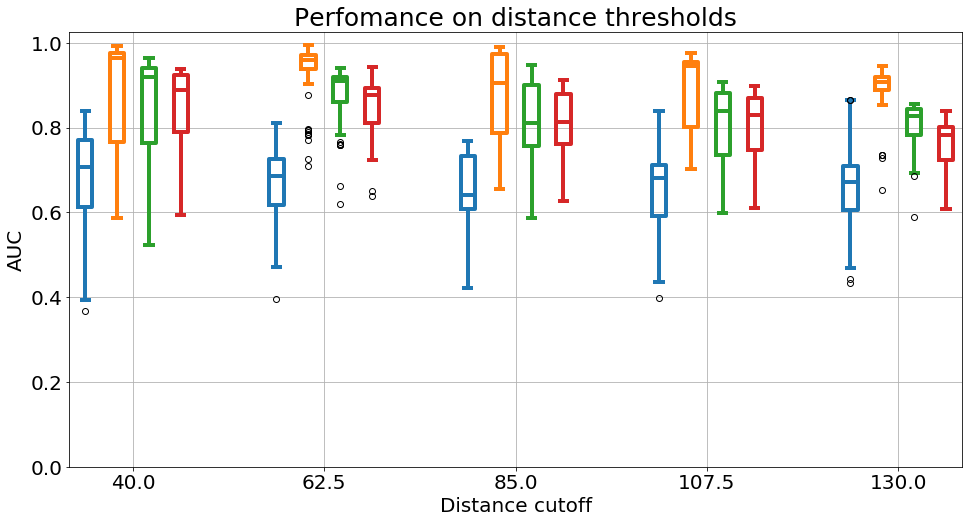

In [1170]:
plot_knn_boxplot(perfomances)

In [1113]:
model_perfomances = {k: [] for k in perfomances.keys()}

In [1116]:
def get_auc_from_knn(knn):
    precisions = knn.get("precisions")
    recalls = knn.get("recalls")
    aucs = [auc(r, p) for r, p in zip(precisions, recalls)]
    return aucs

In [1120]:
for i in range(75):
    for model, metric in perfomances.items():
        aucs = get_auc_from_knn(metric.get("knn")[i])
        model_perfomances[model].append(aucs)

In [1149]:
a = np.array(model_perfomances["SSD_LF"]).reshape((5, 75))
b = np.array(model_perfomances["SSD_BF"]).reshape((5, 75))
c = np.array(model_perfomances["RCNN_LF"]).reshape((5, 75))
d = np.array(model_perfomances["RCNN_BF"]).reshape((5, 75))

x = [a,b,c,d]

In [ ]:
for i in range()

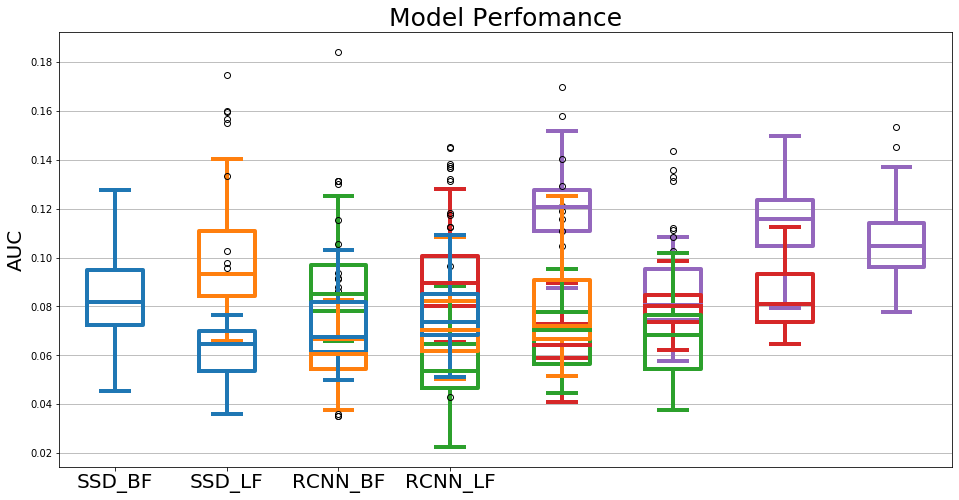

In [1152]:
plt.figure(figsize=(16,8))
plt.title("Model Perfomance", fontsize=25)
for k, m in enumerate(x):
    for i in range(m.shape[0]):
        colors = list(mcolors.TABLEAU_COLORS.values())
        box = plt.boxplot(m[i], positions=[k+i], widths=0.5)
        for box_property in box.values():
            setp(box_property, color=colors[i], lw=4)

plt.xticks(ticks=[0,1,2,3], labels=[model for model in perfomances.keys()], fontsize=20)
# plt.yticks(np.linspace(0.5, 1, 6), fontsize=20)
plt.ylabel("AUC", fontsize=20)
plt.grid(axis="y")
plt.show()

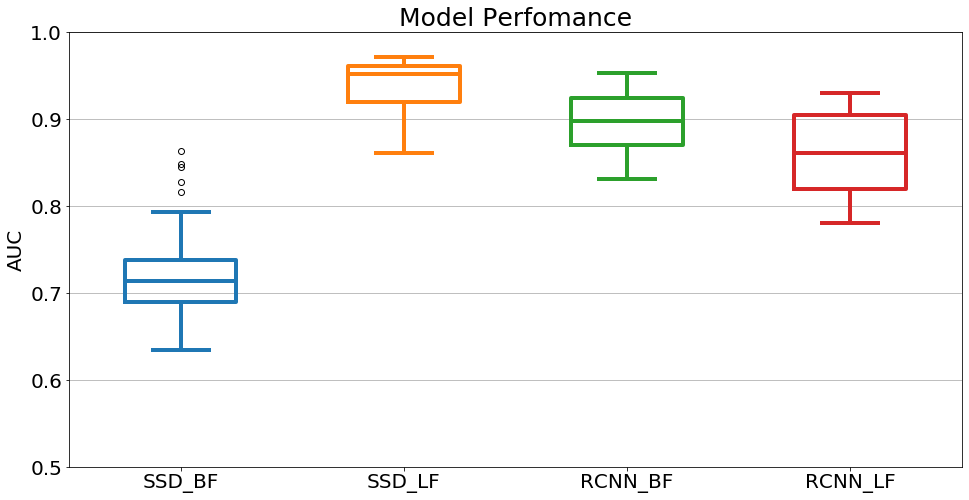

In [1046]:
plt.figure(figsize=(16,8))
plt.title("Model Perfomance", fontsize=25)
for i, (model, metric) in enumerate(perfomances.items()):
    colors = list(mcolors.TABLEAU_COLORS.values())
    box = plt.boxplot(metric.get("auc"), positions=[i], widths=0.5)
    for box_property in box.values():
        setp(box_property, color=colors[i], lw=4)
        

plt.xticks(ticks=[0,1,2,3], labels=[model for model in perfomances.keys()], fontsize=20)
plt.yticks(np.linspace(0.5, 1, 6), fontsize=20)
plt.ylabel("AUC", fontsize=20)
plt.grid(axis="y")
plt.show()

In [988]:
prec_path = join(path, "precision_recall_curves")

C:\Users\N.Jabareen\.conda\envs\tf_detection_api_cpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



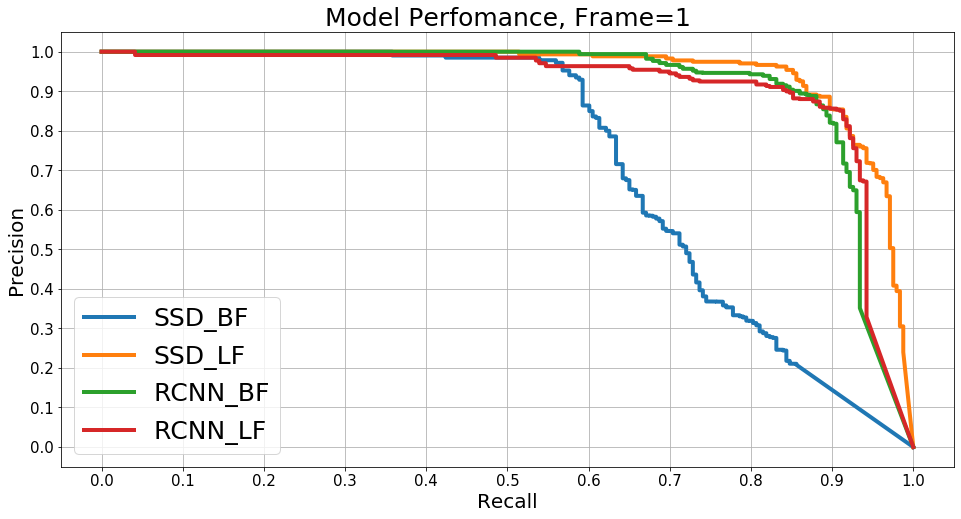

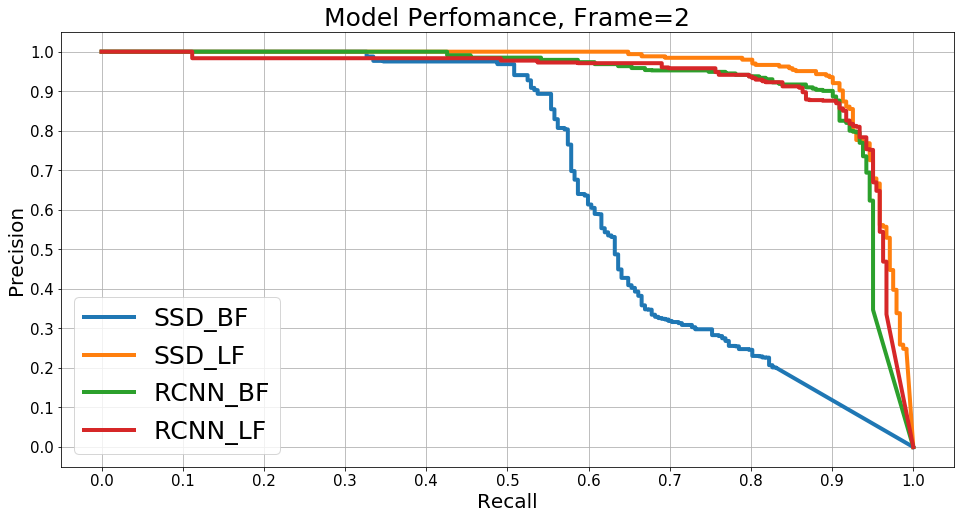

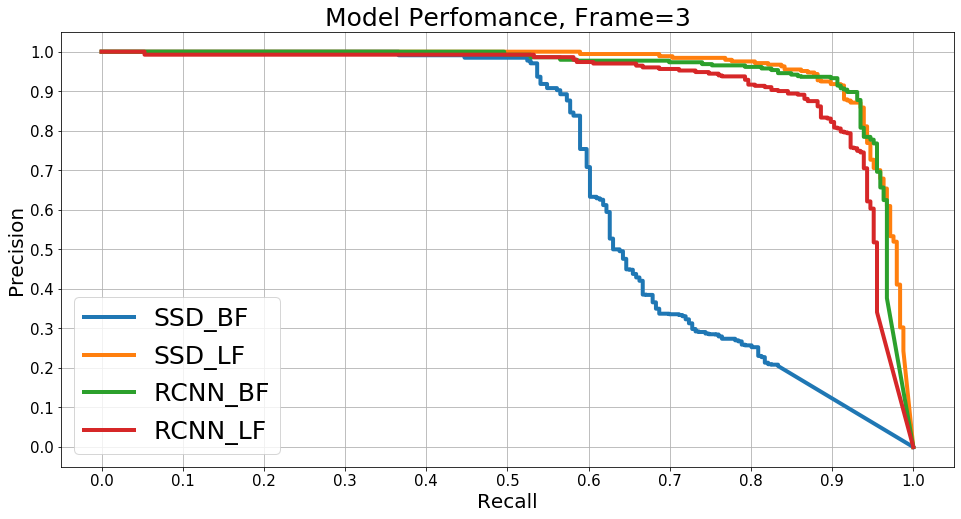

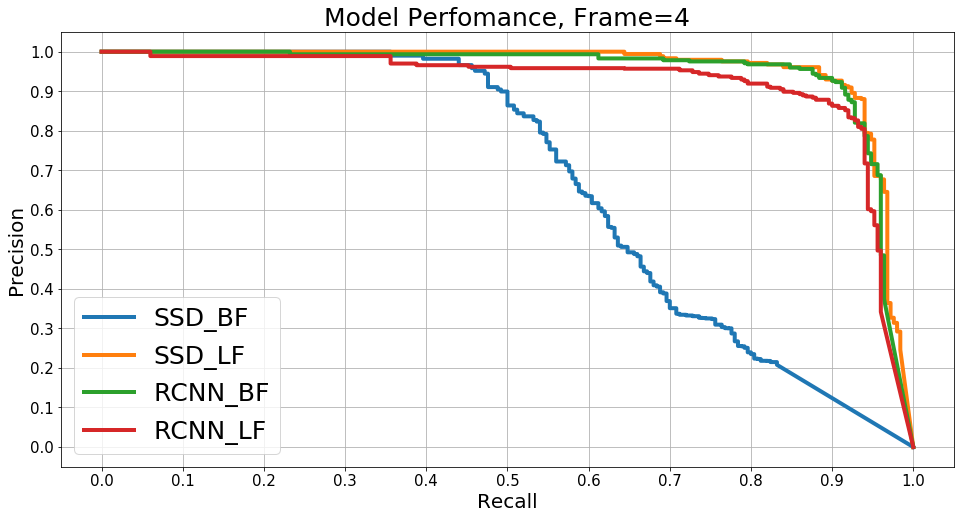

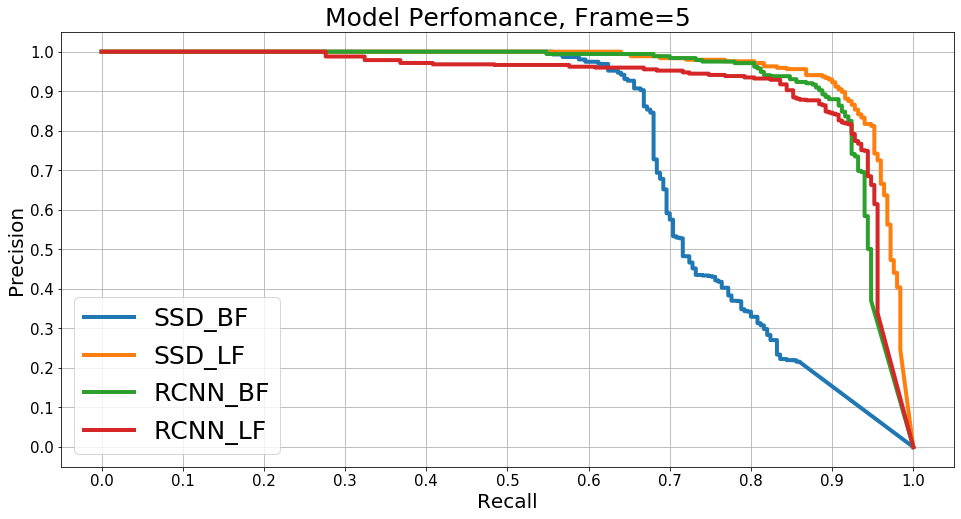

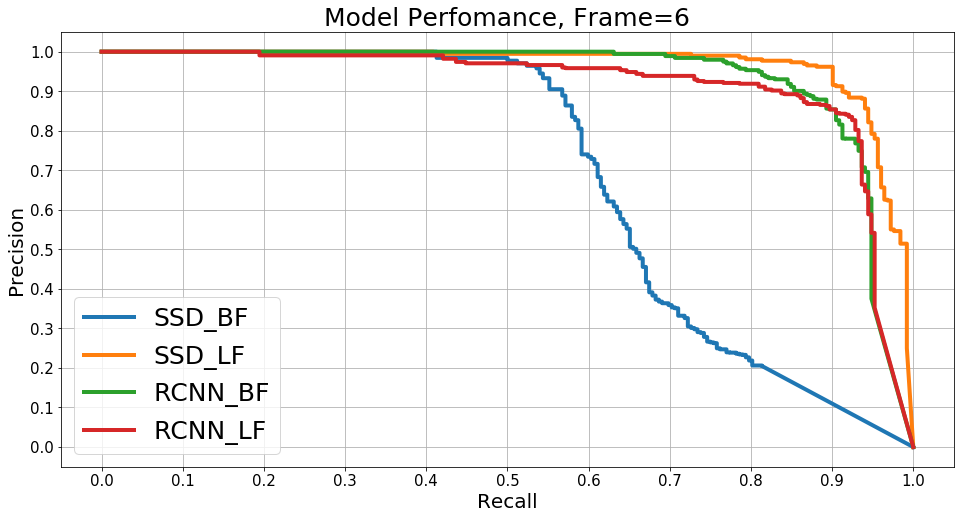

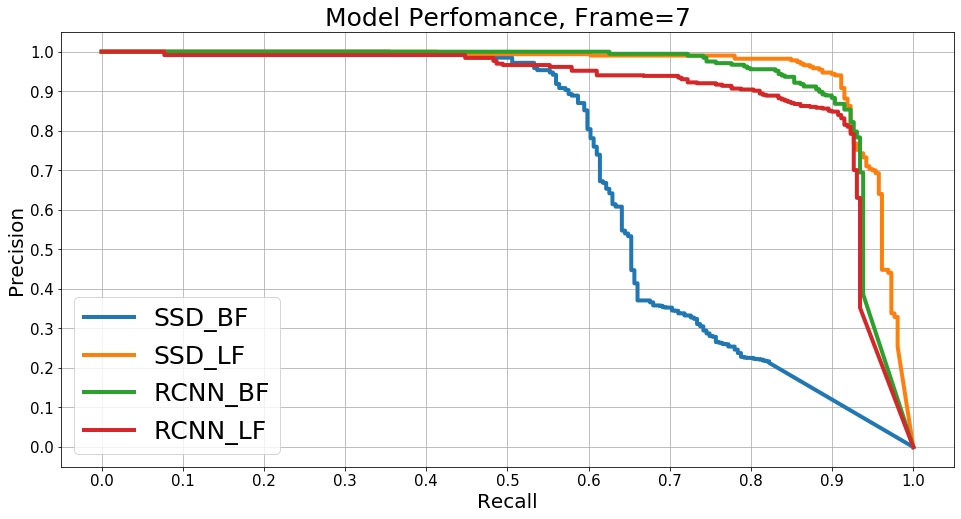

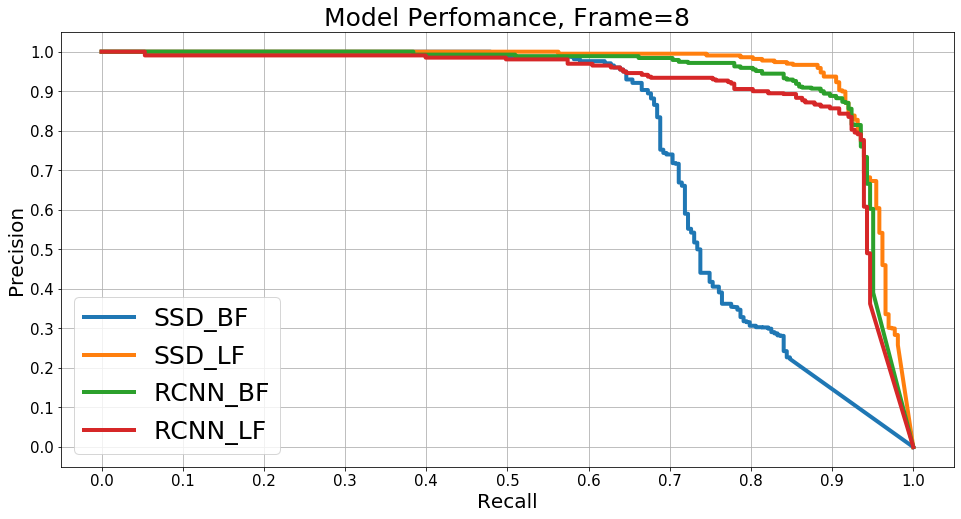

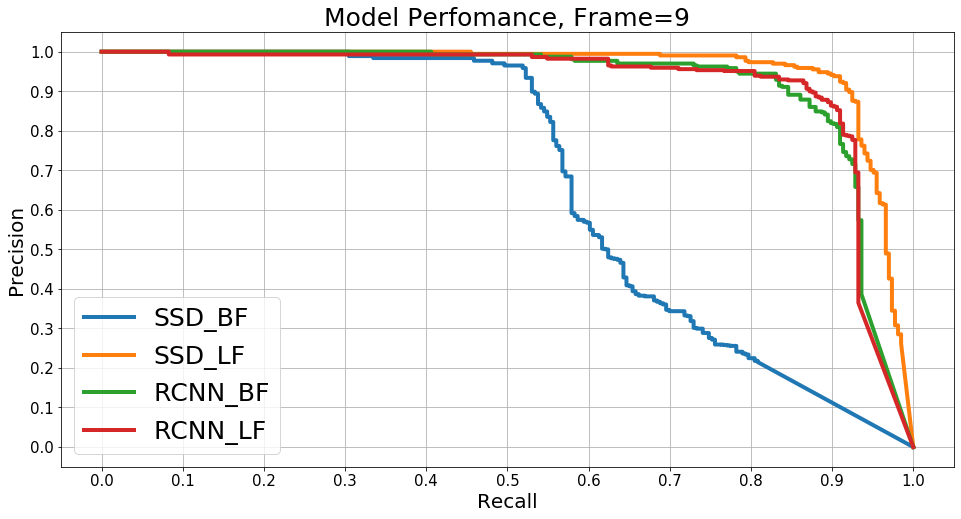

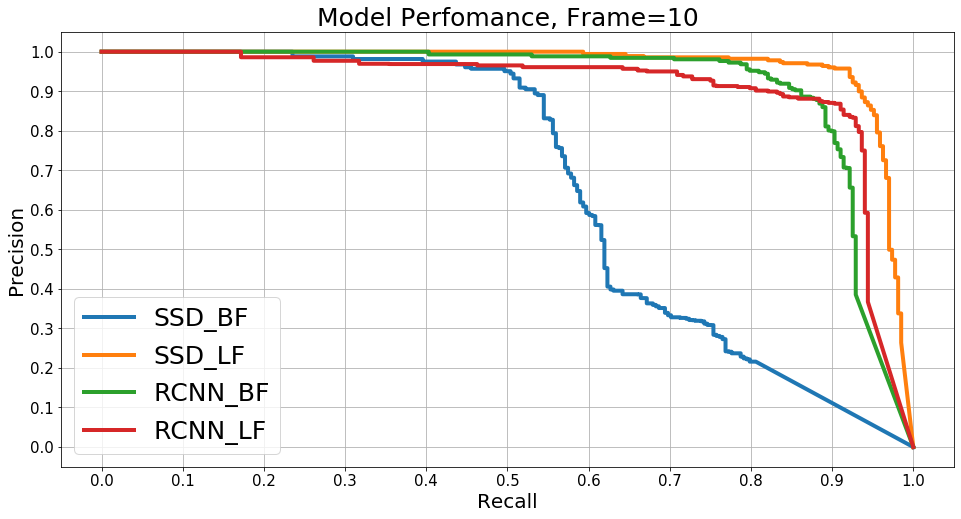

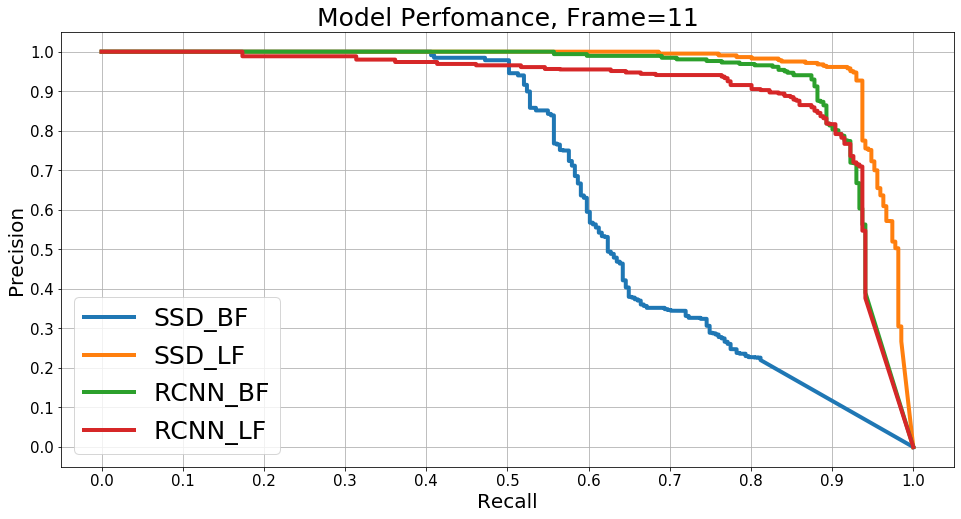

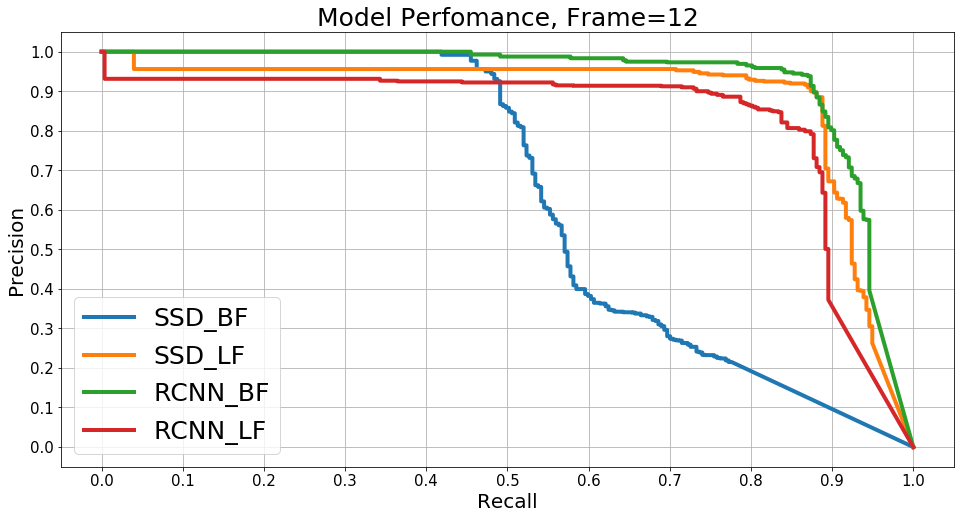

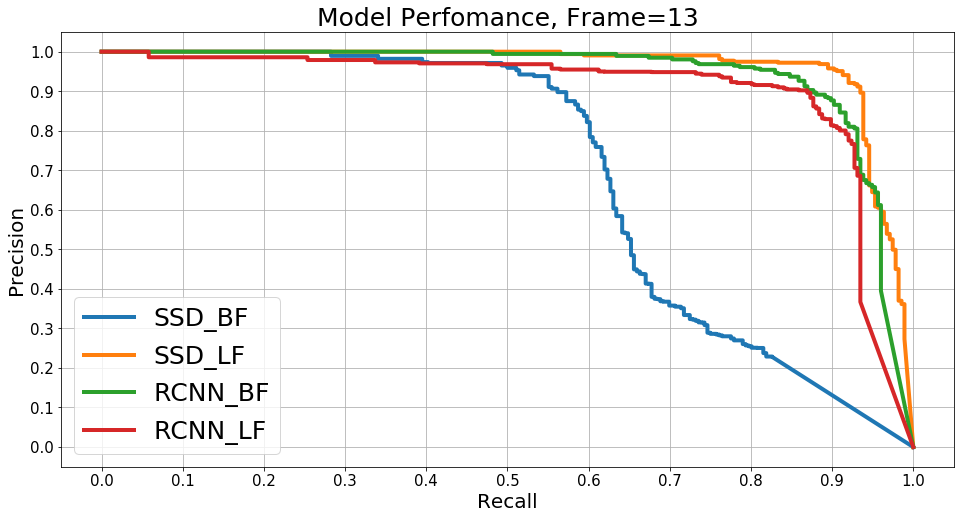

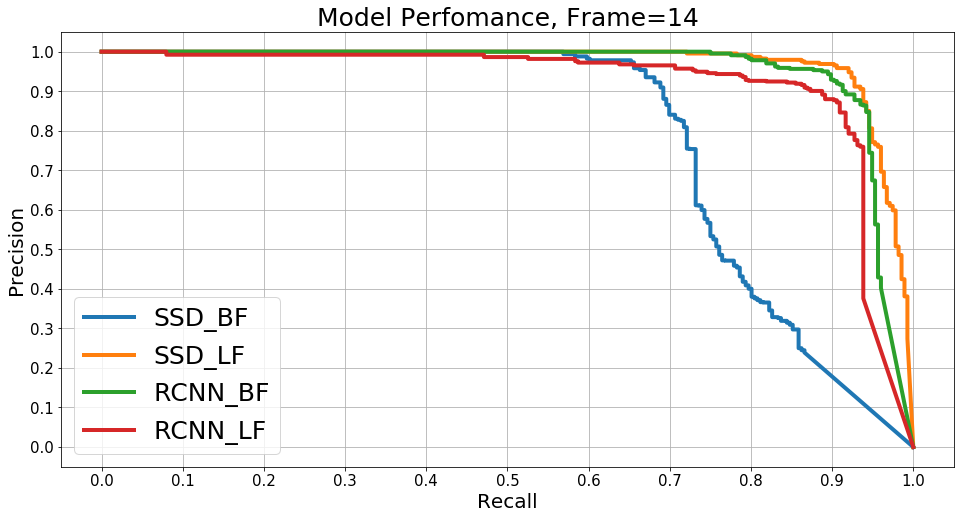

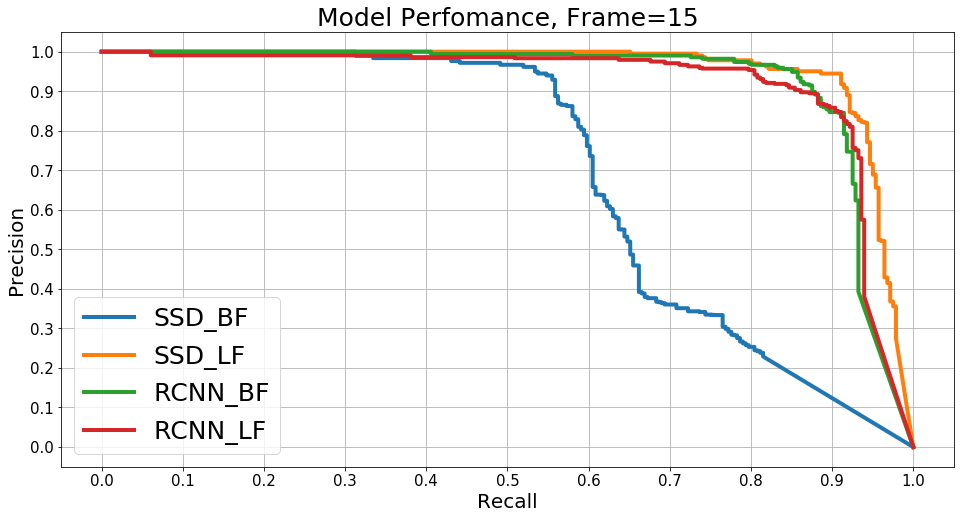

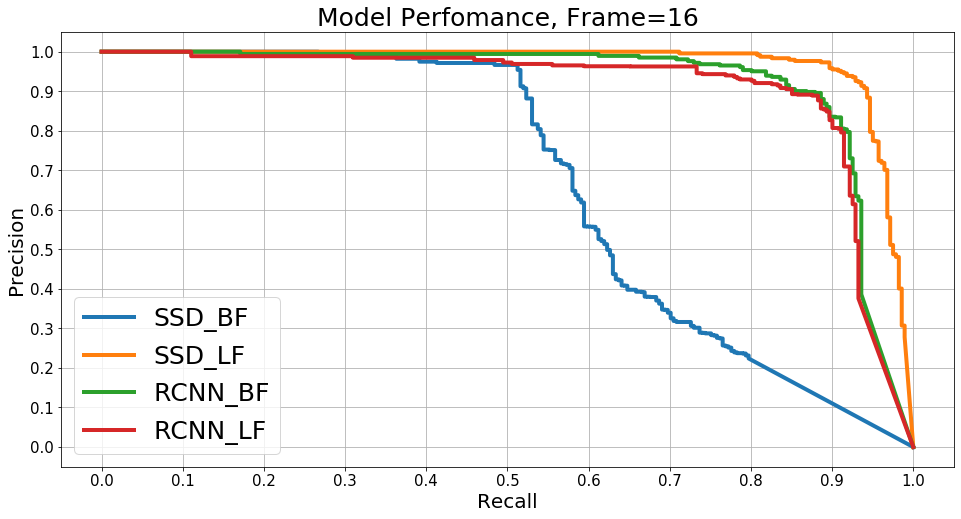

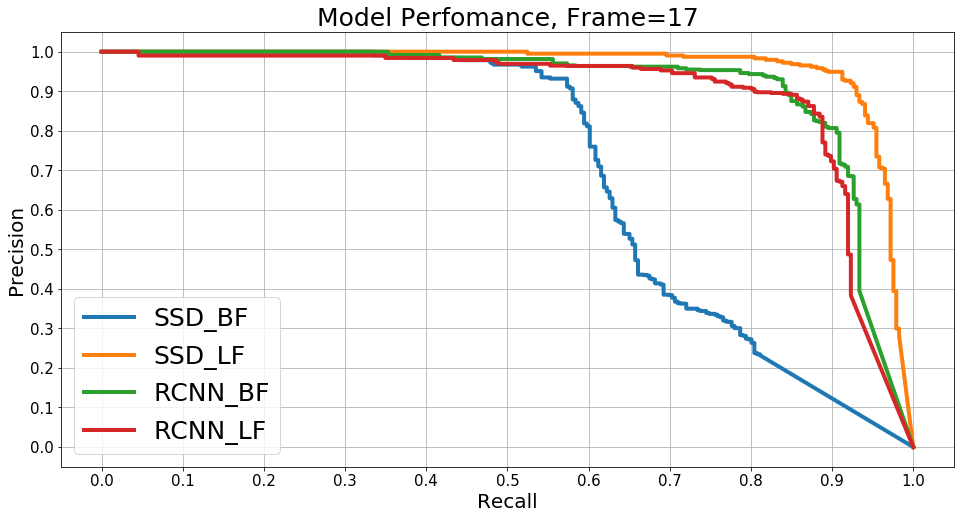

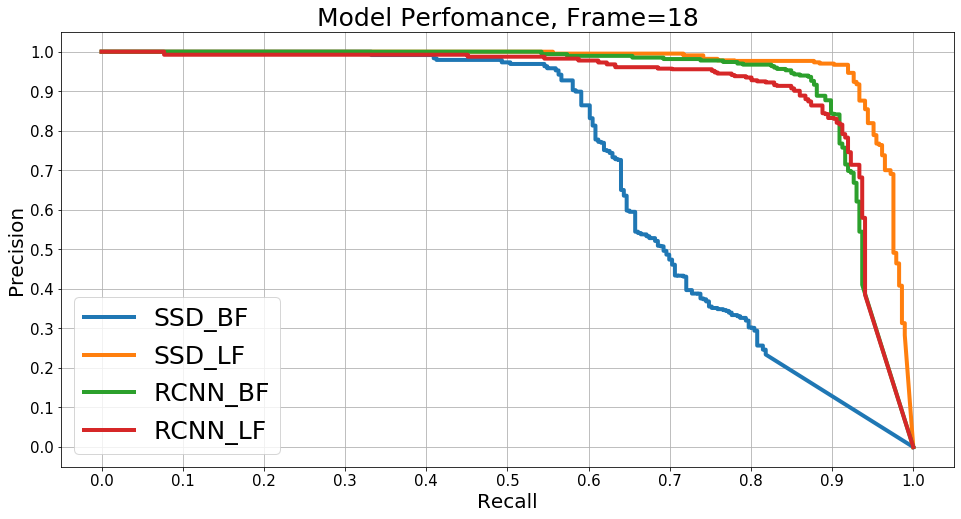

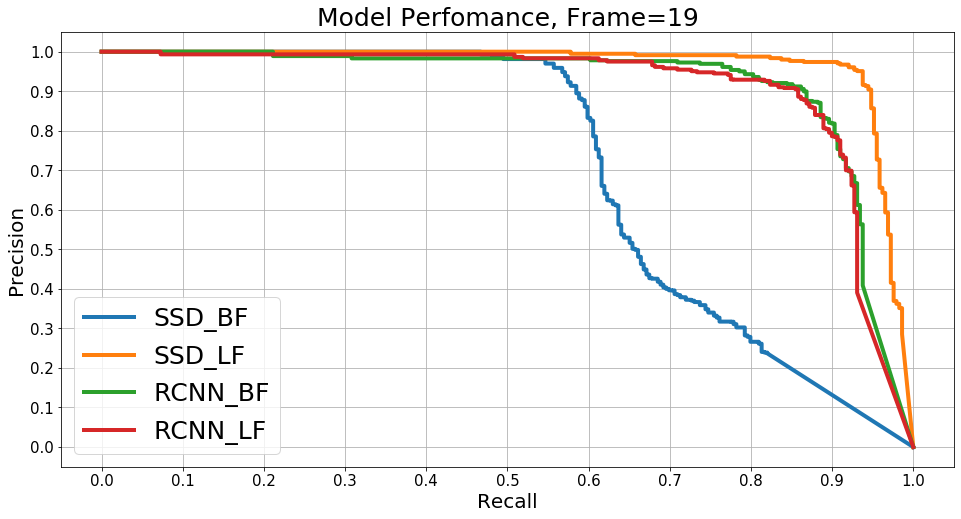

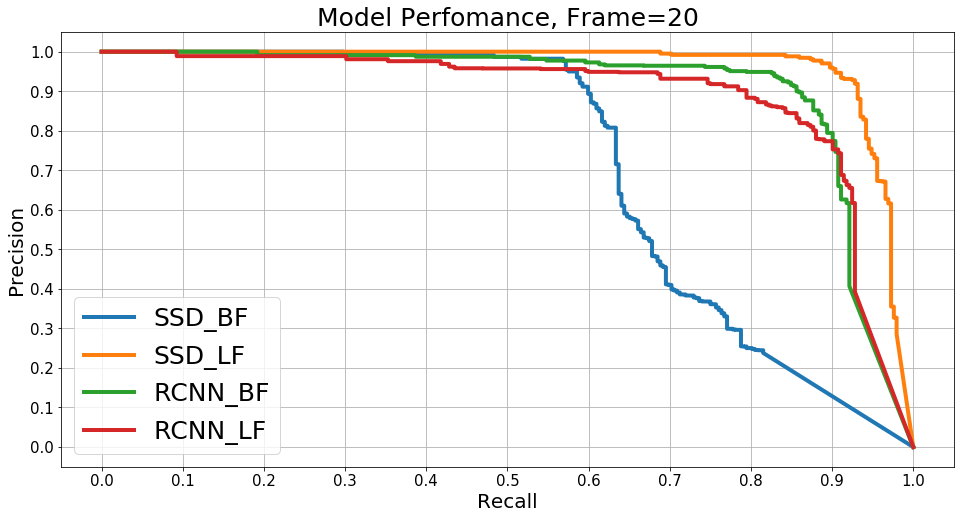

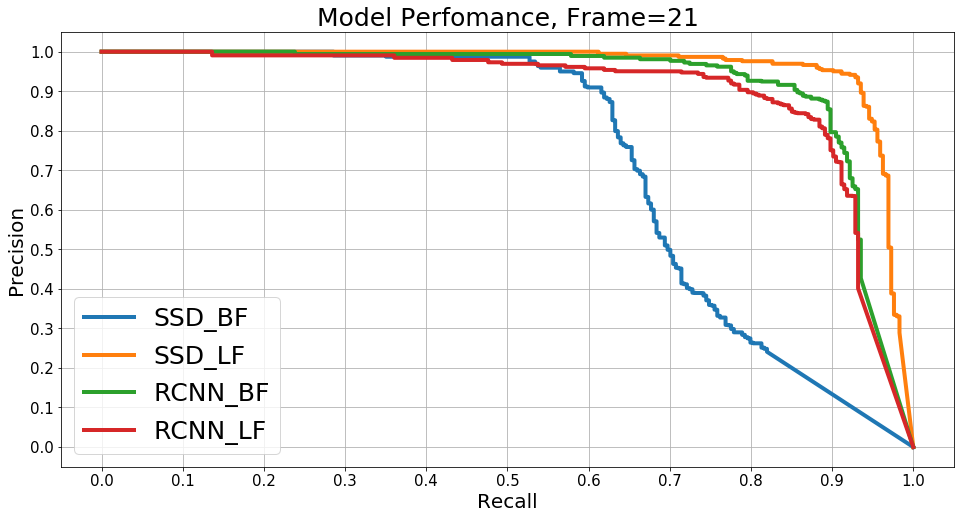

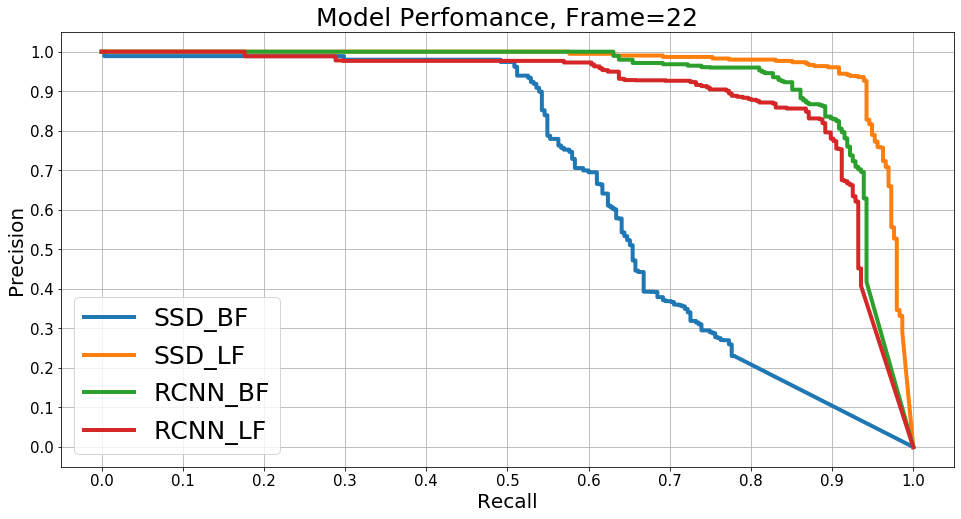

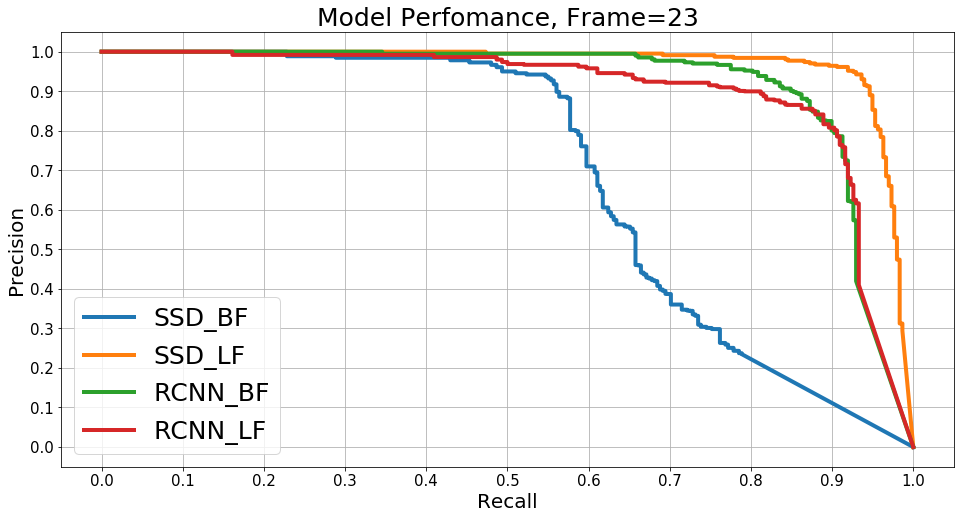

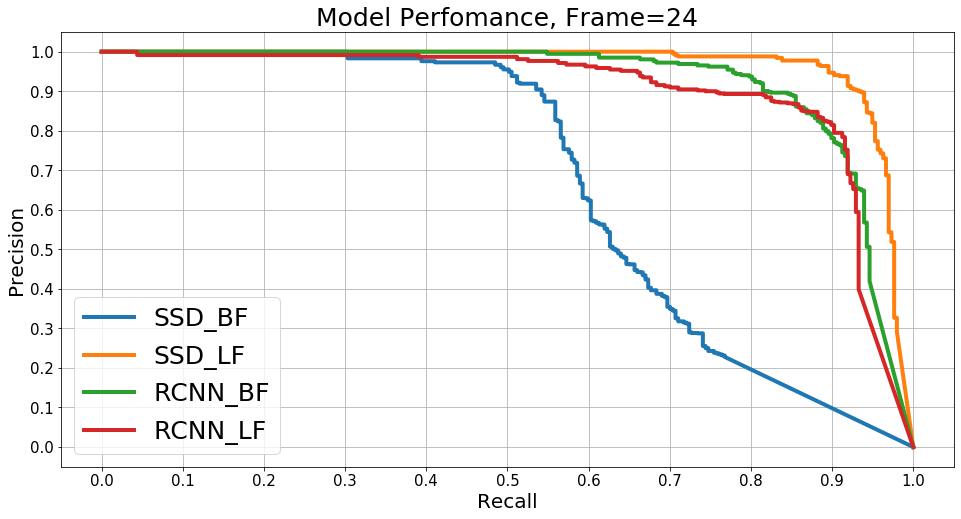

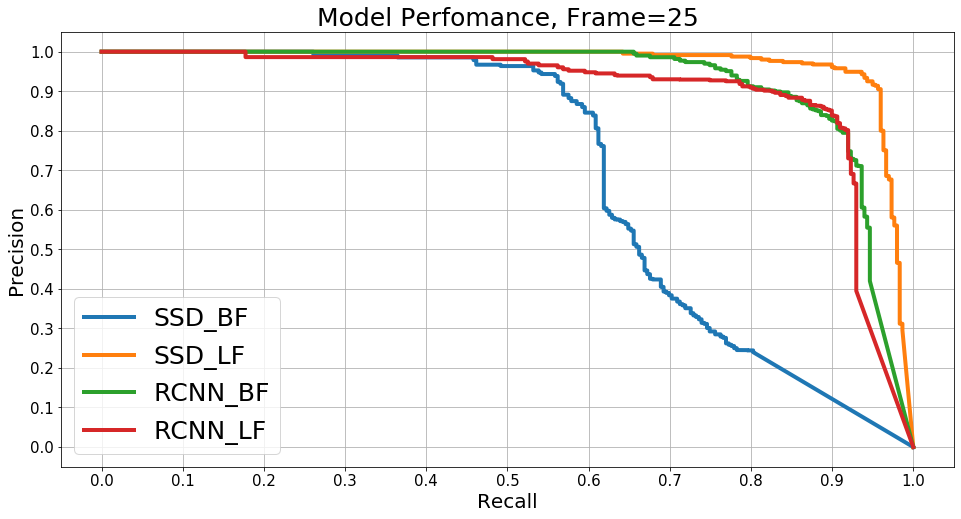

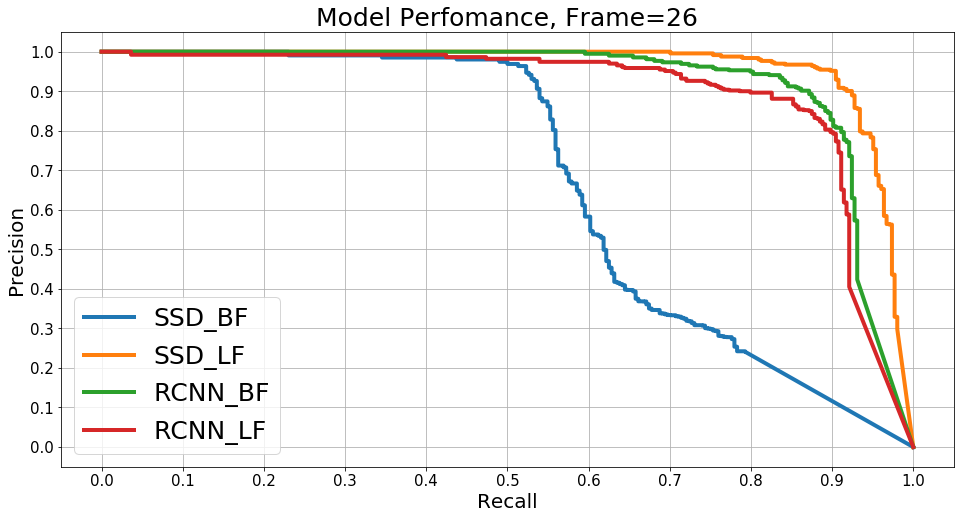

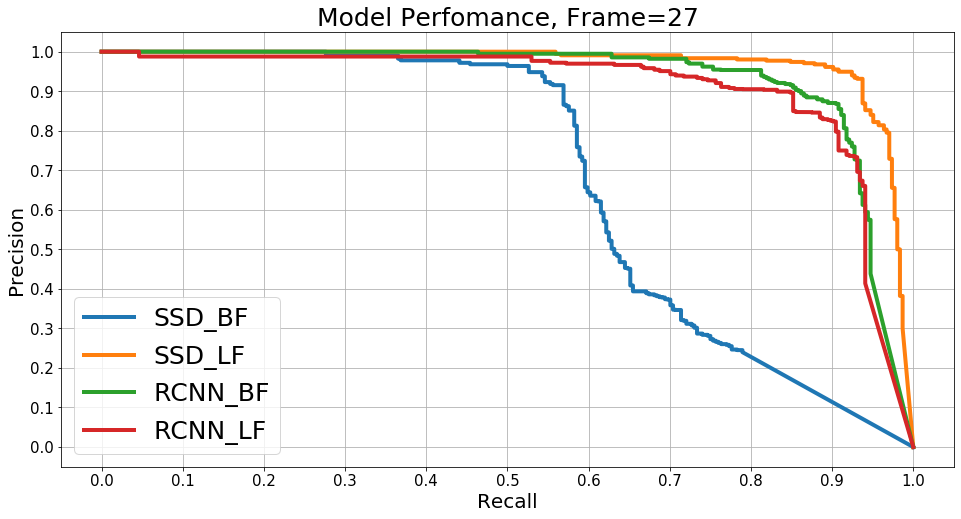

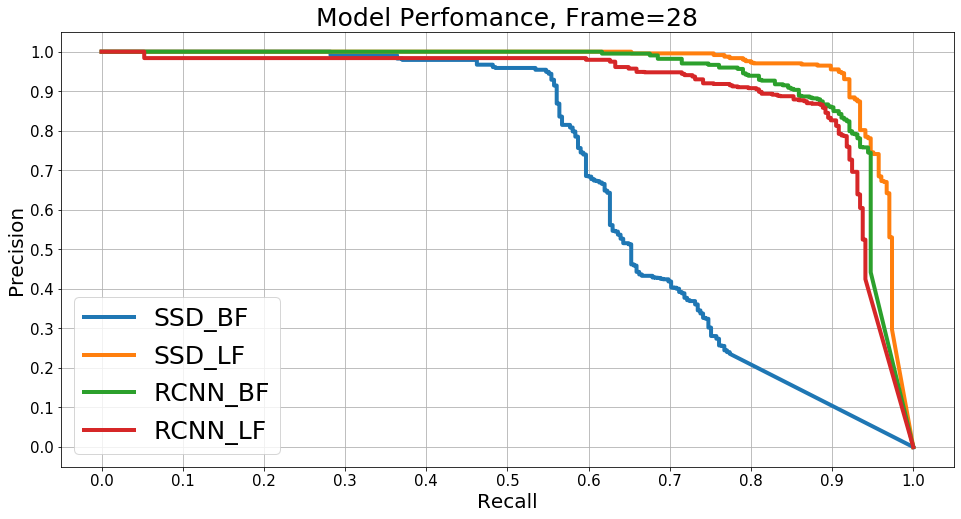

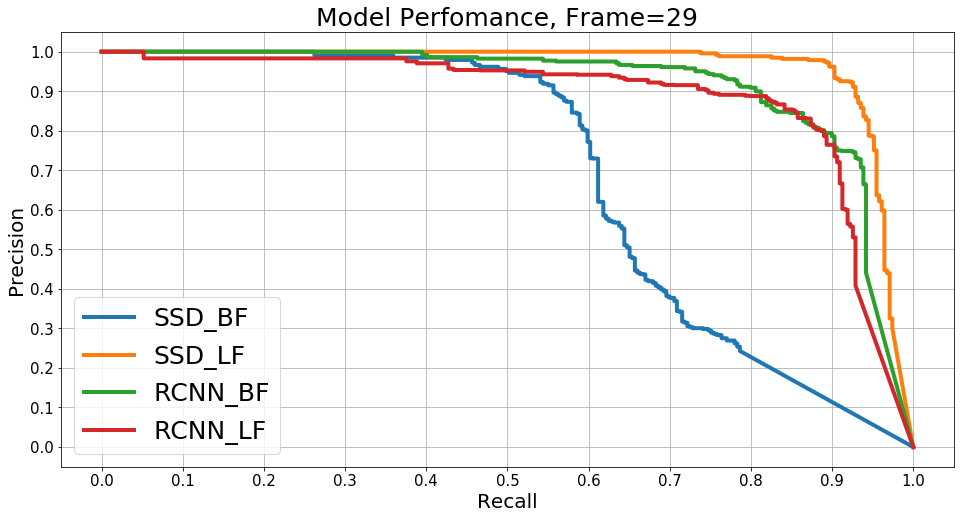

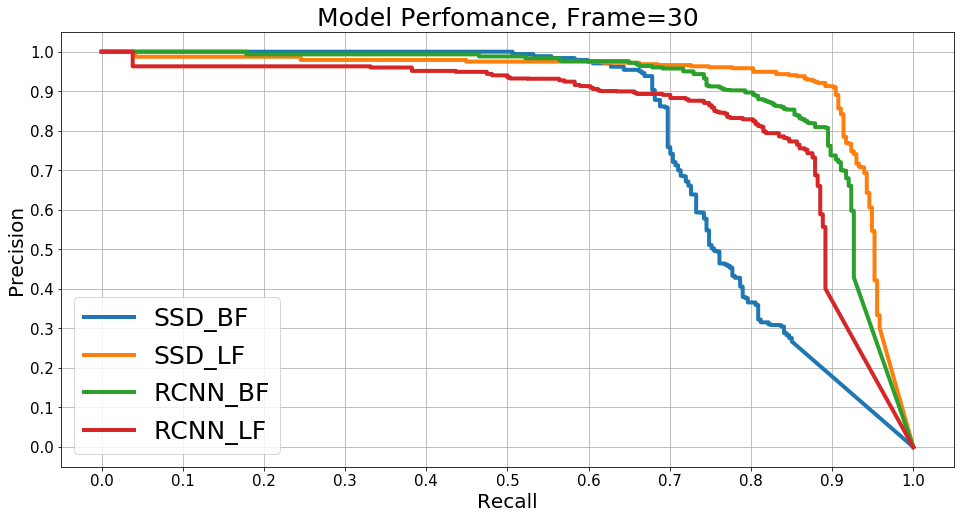

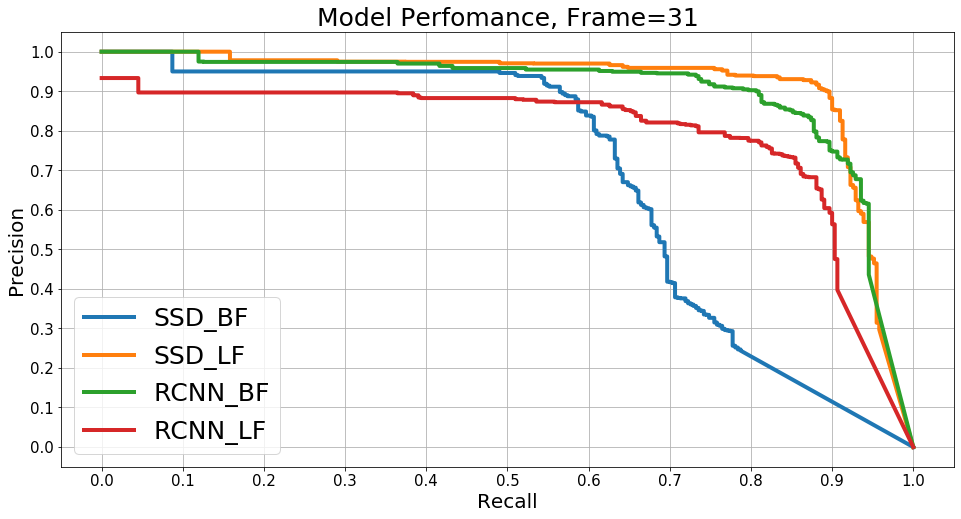

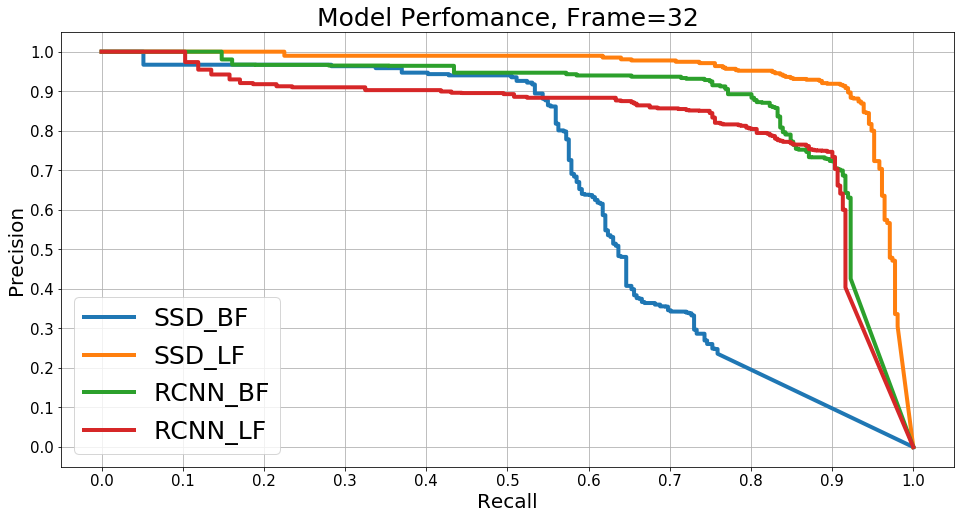

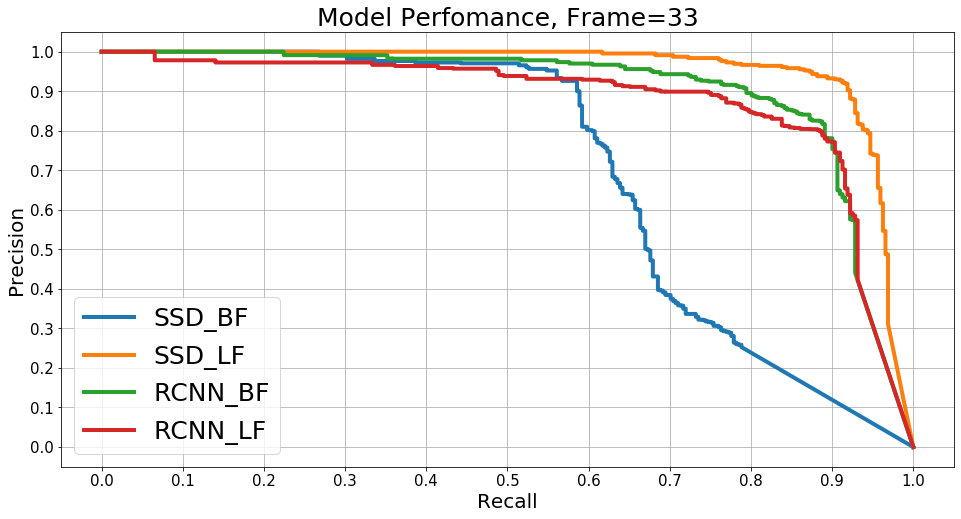

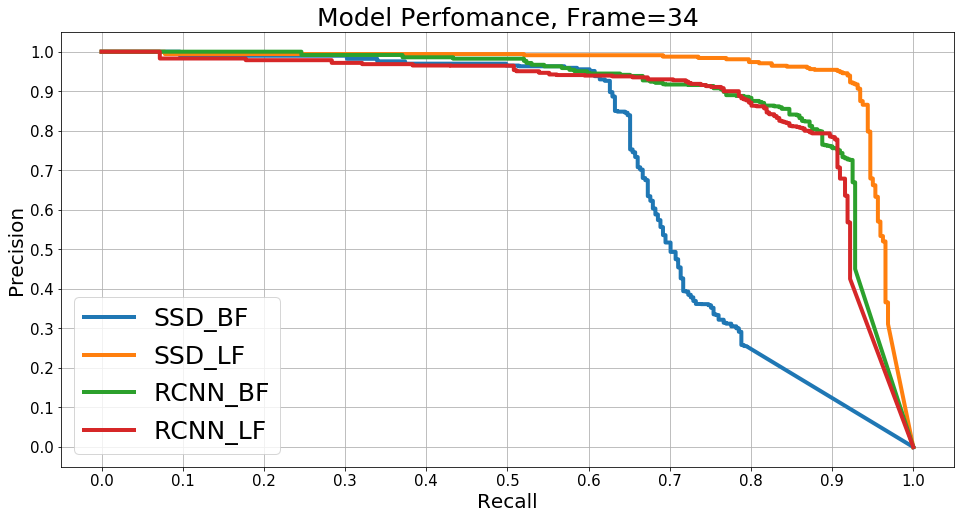

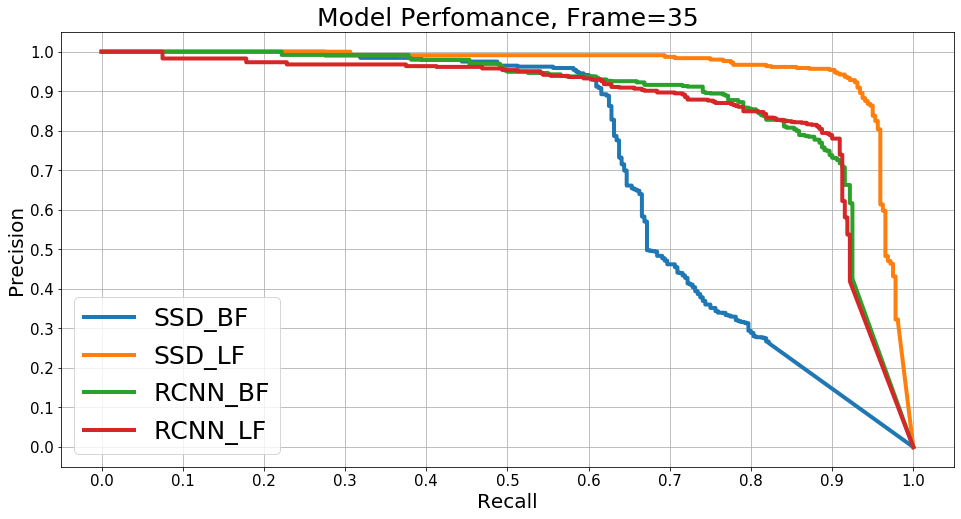

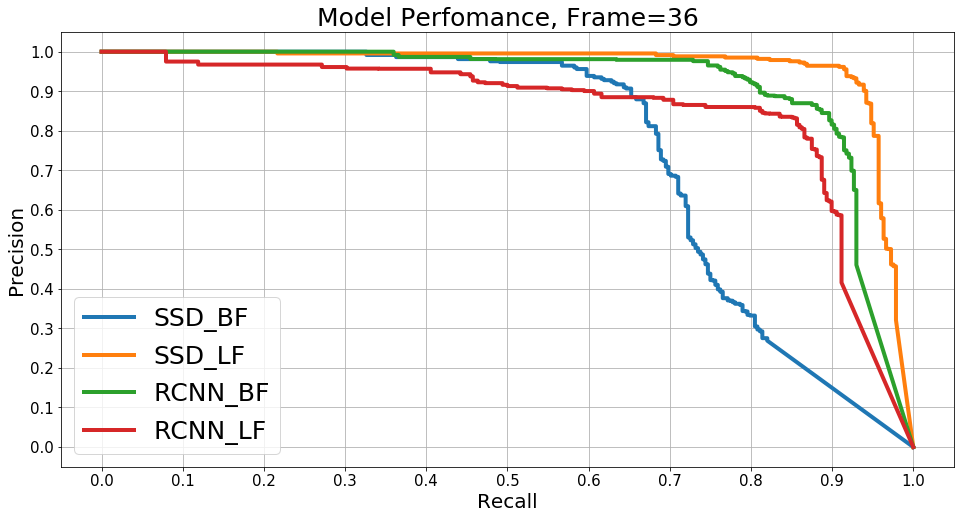

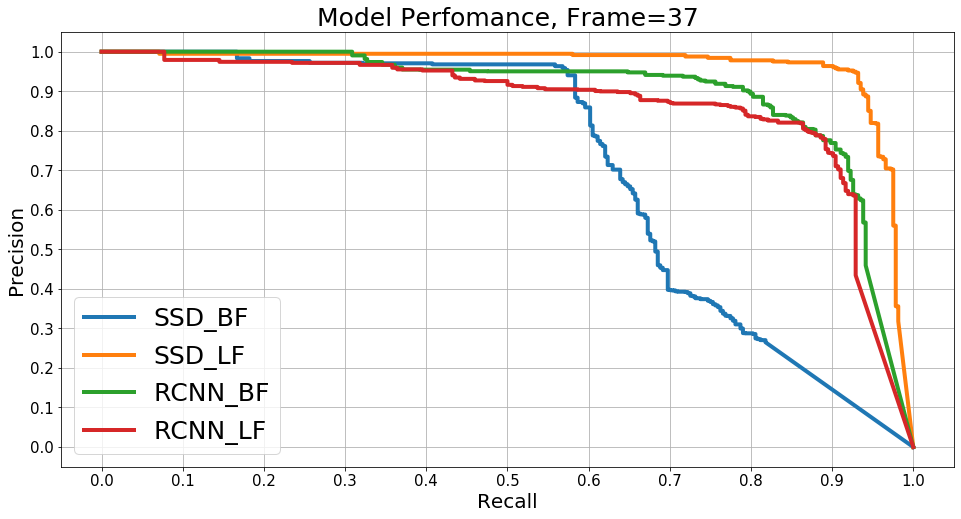

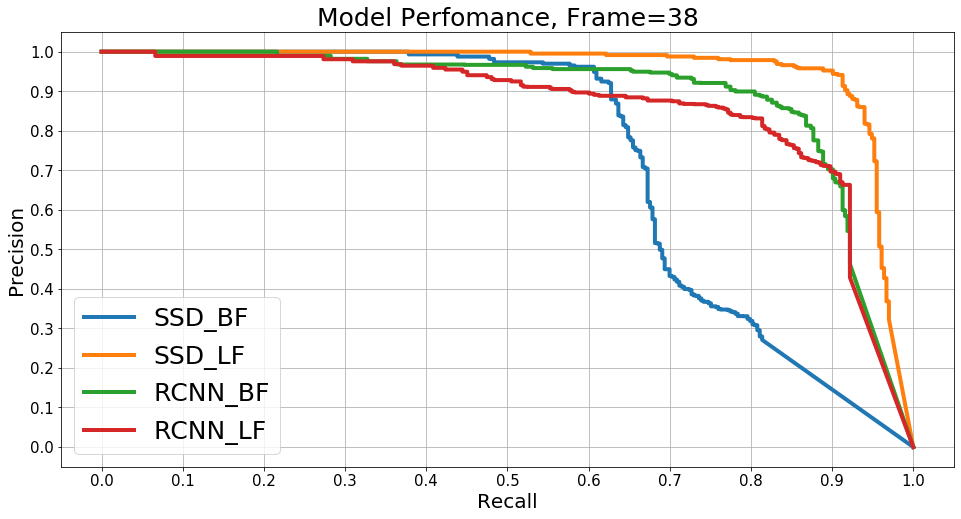

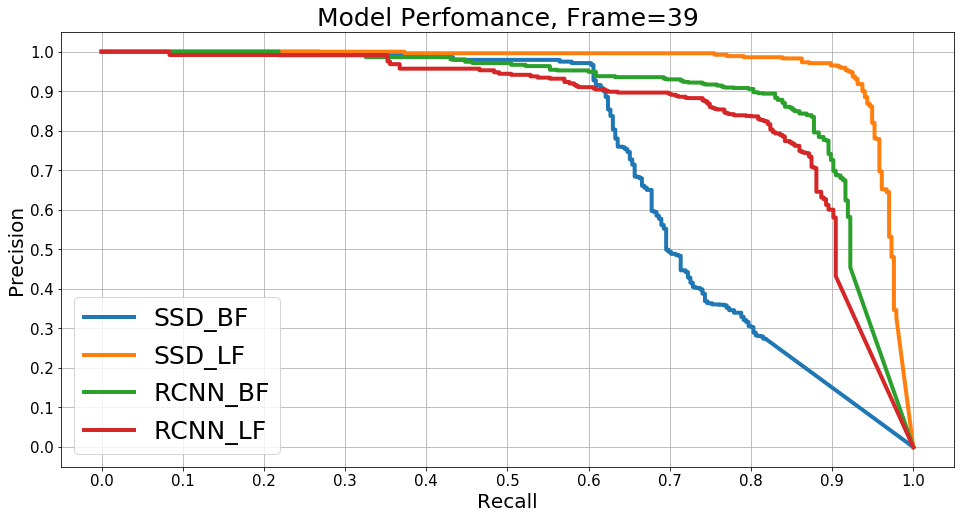

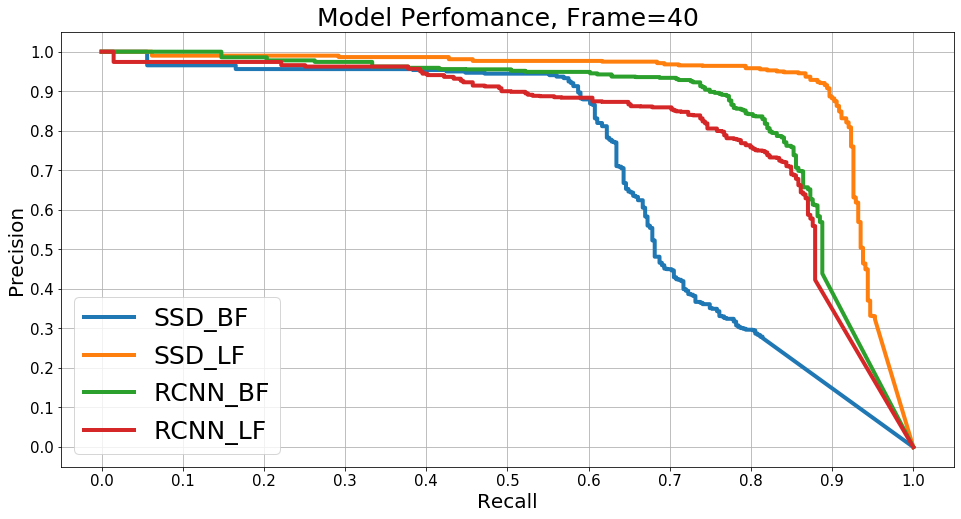

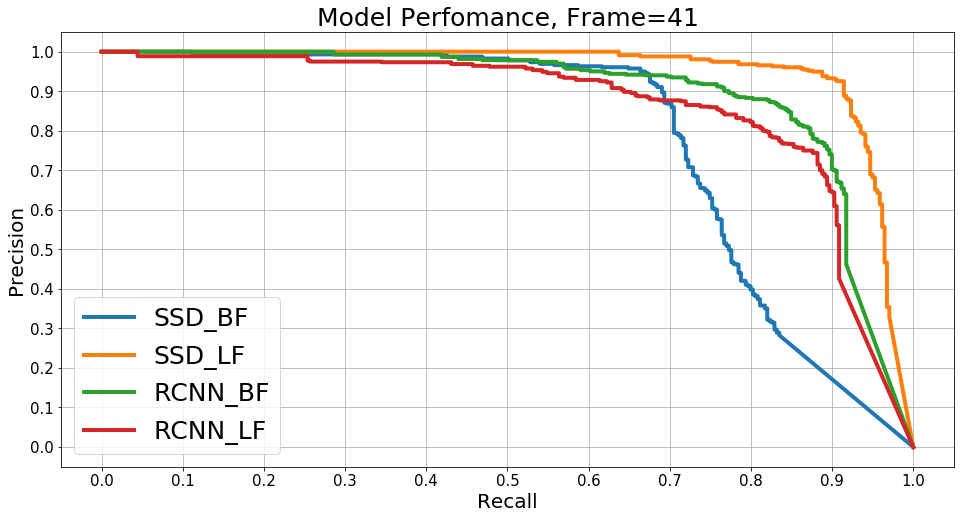

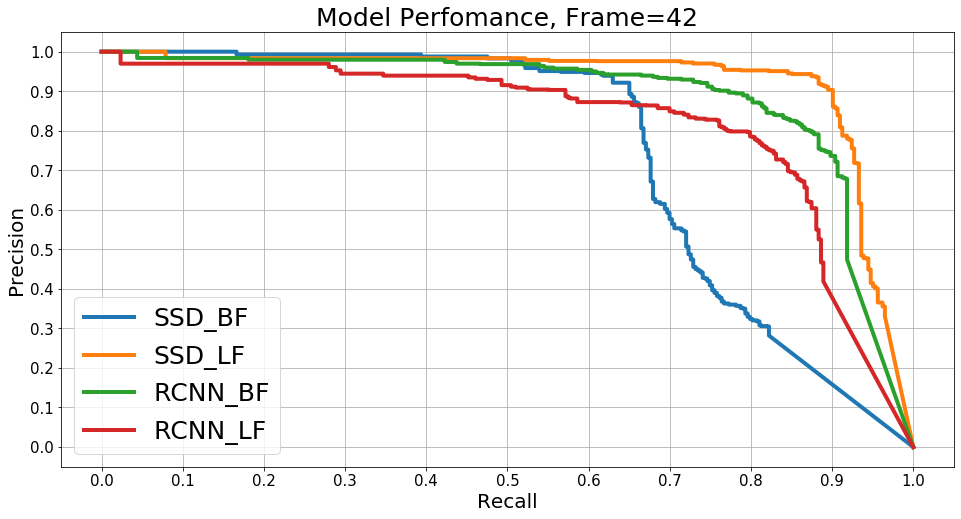

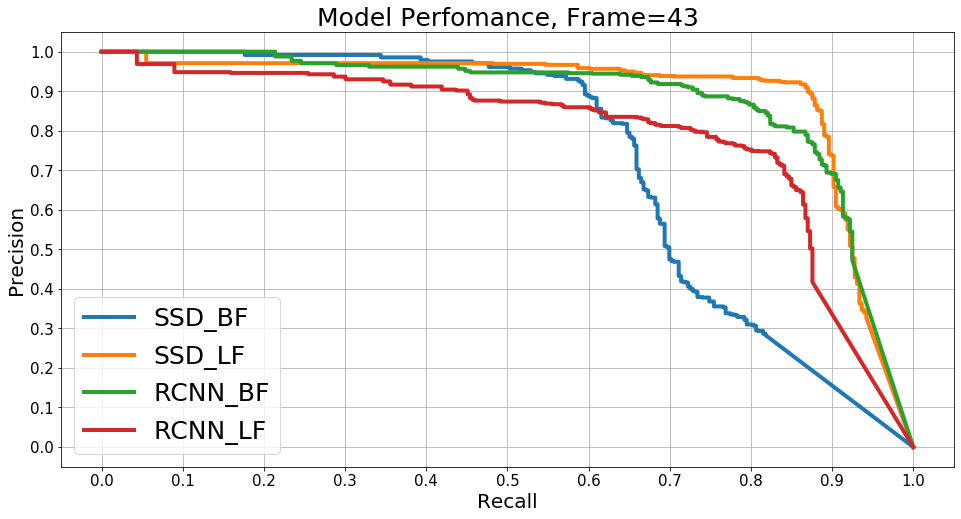

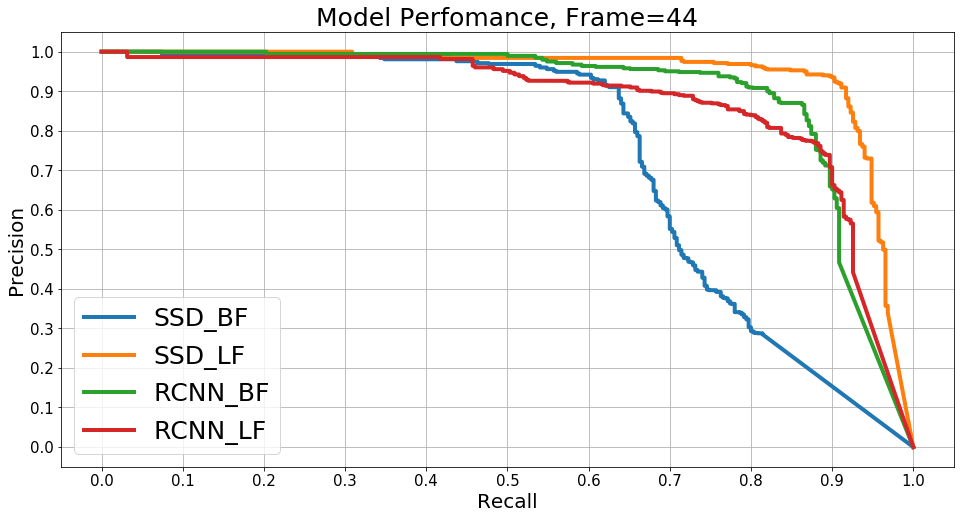

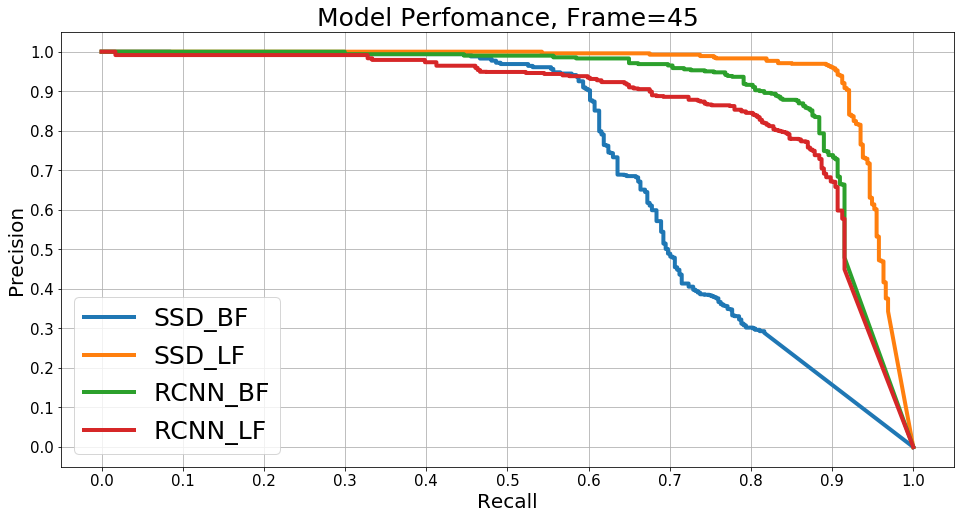

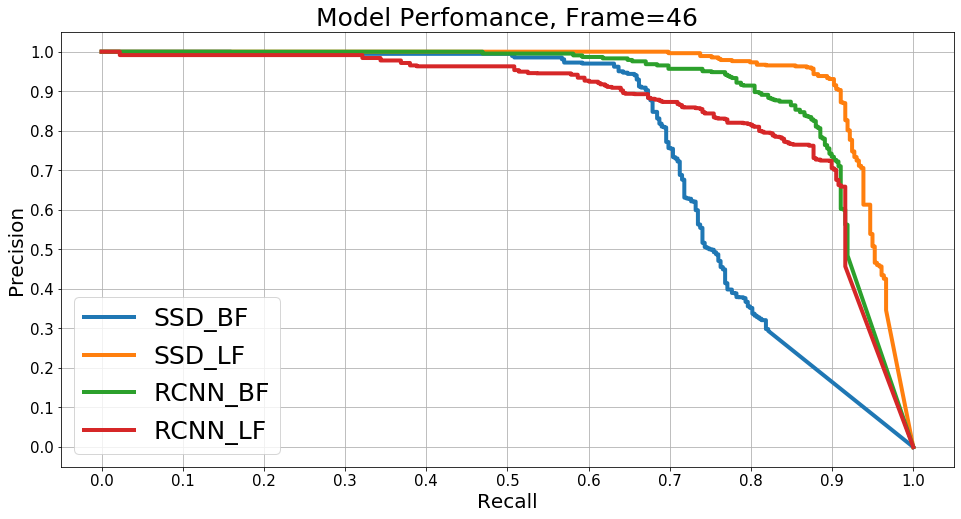

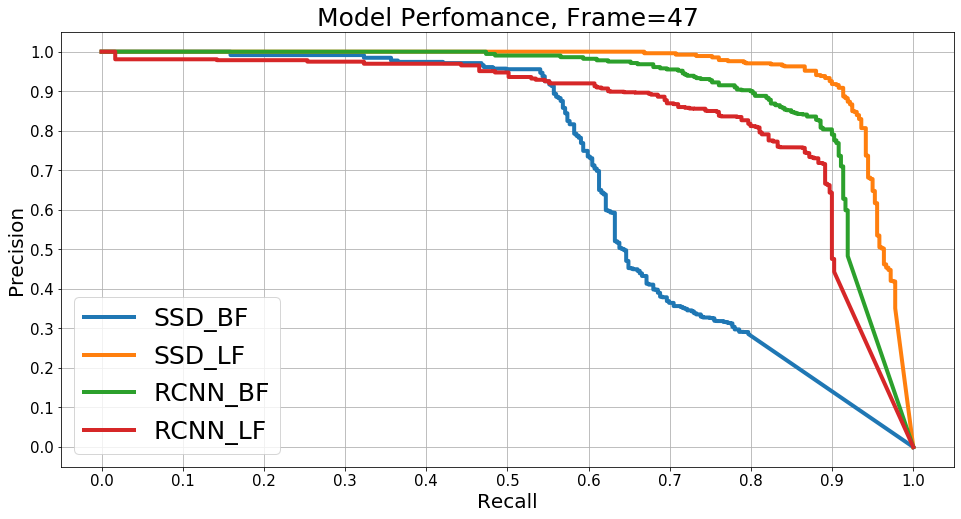

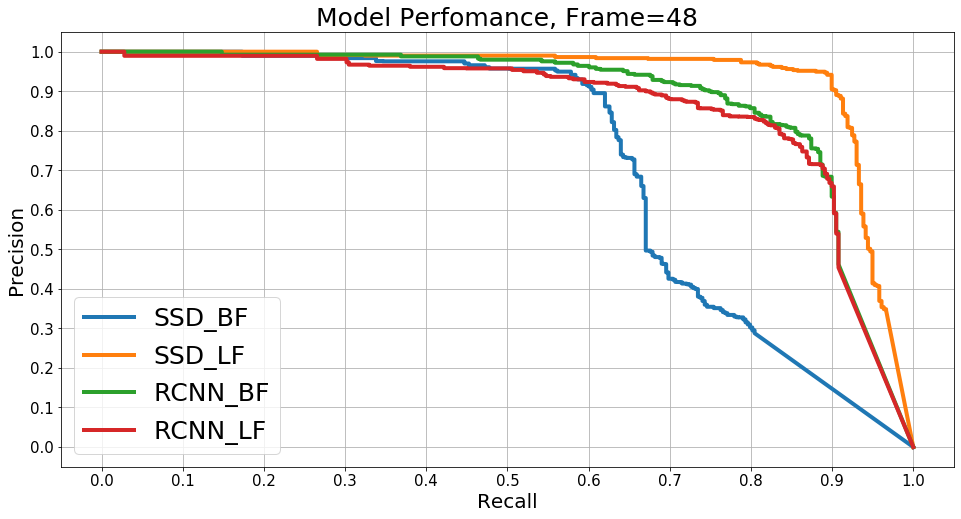

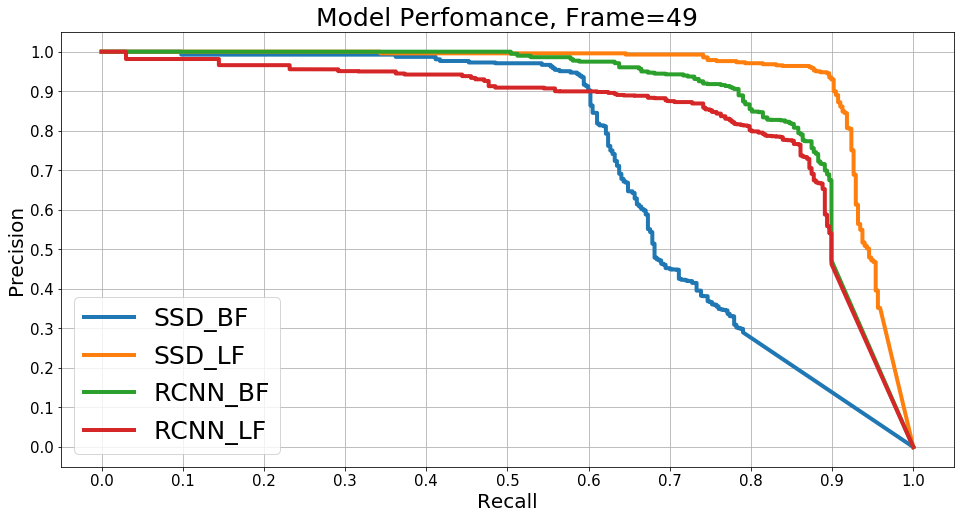

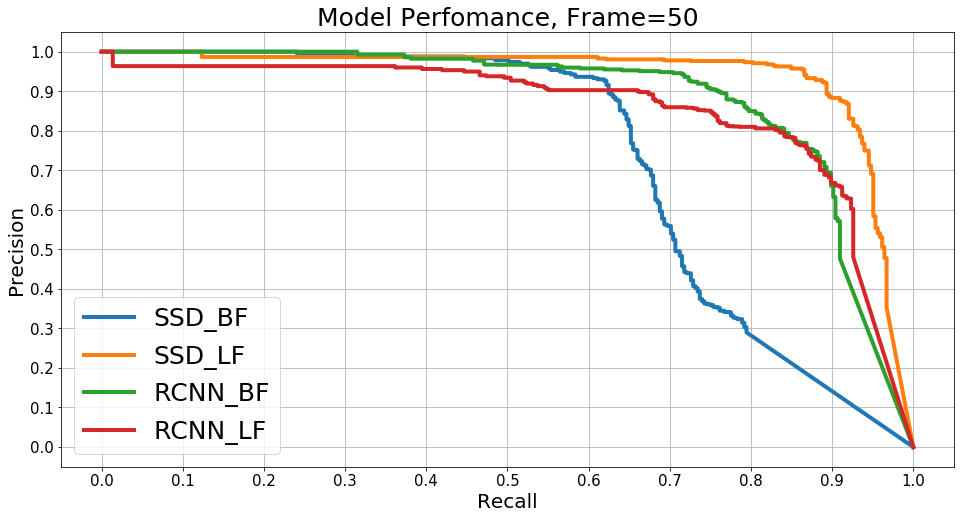

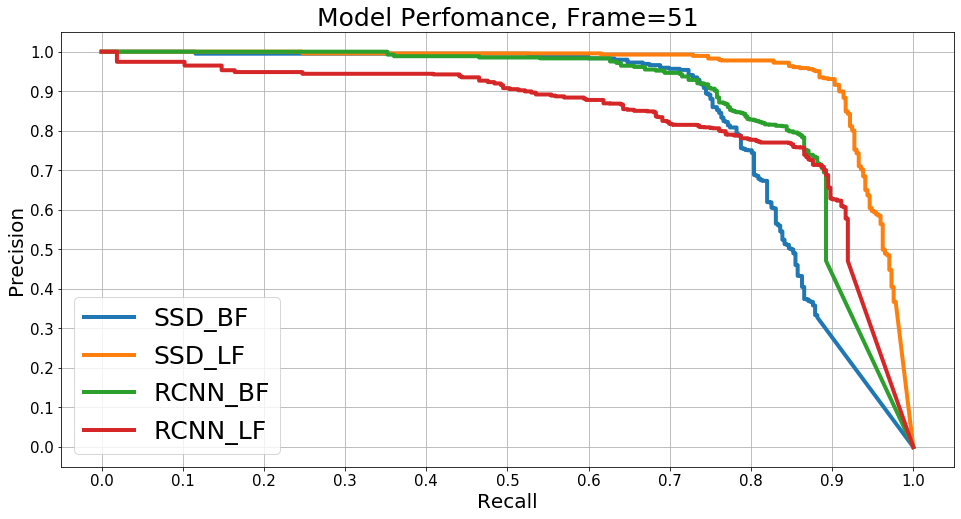

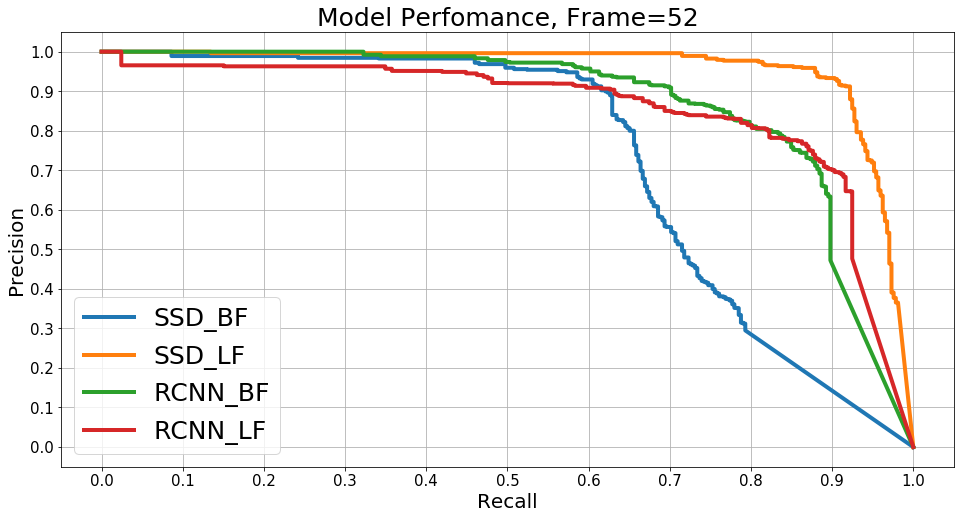

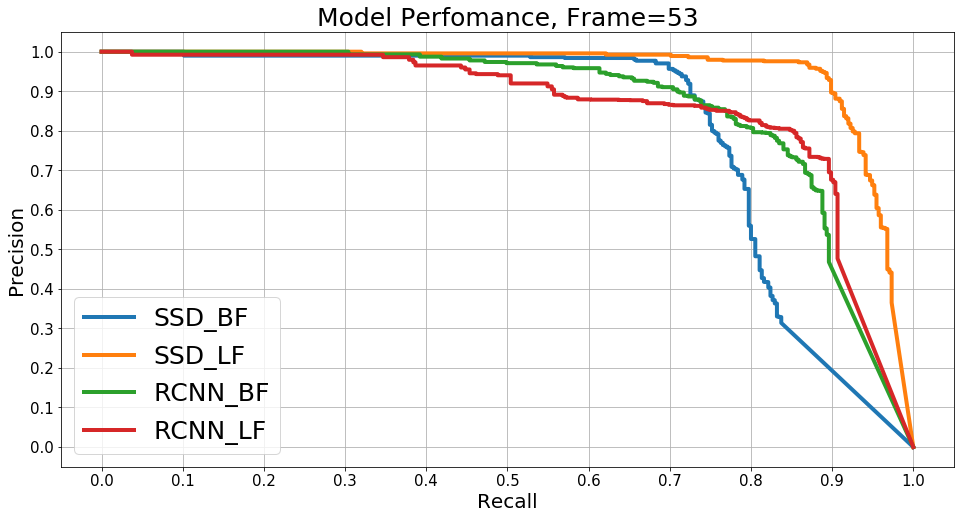

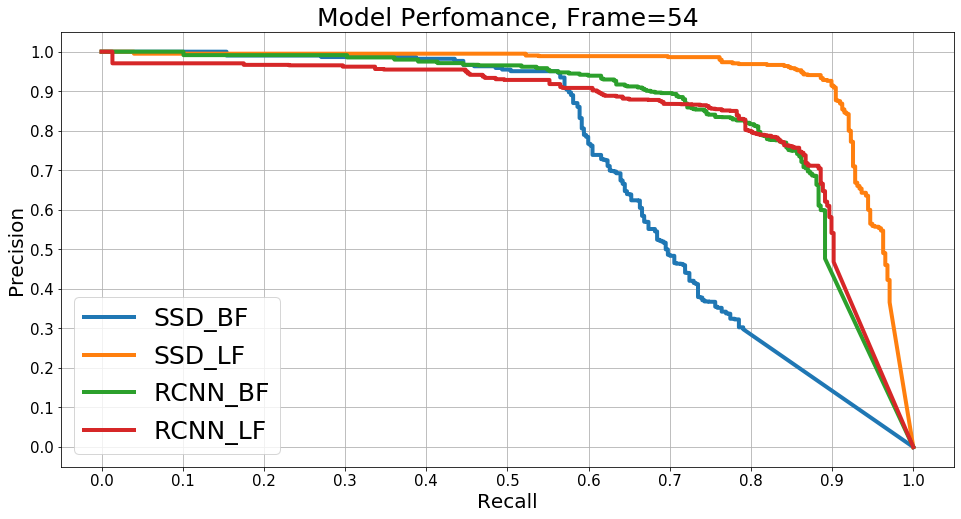

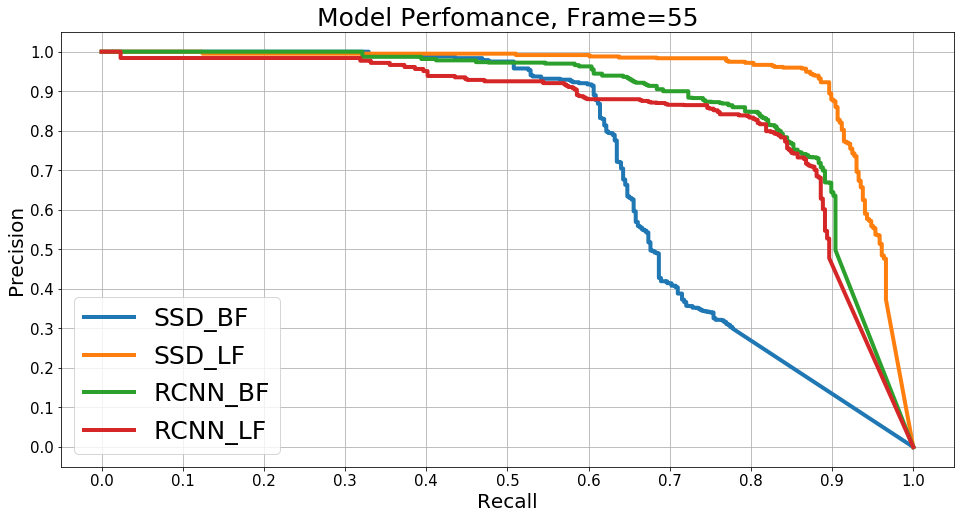

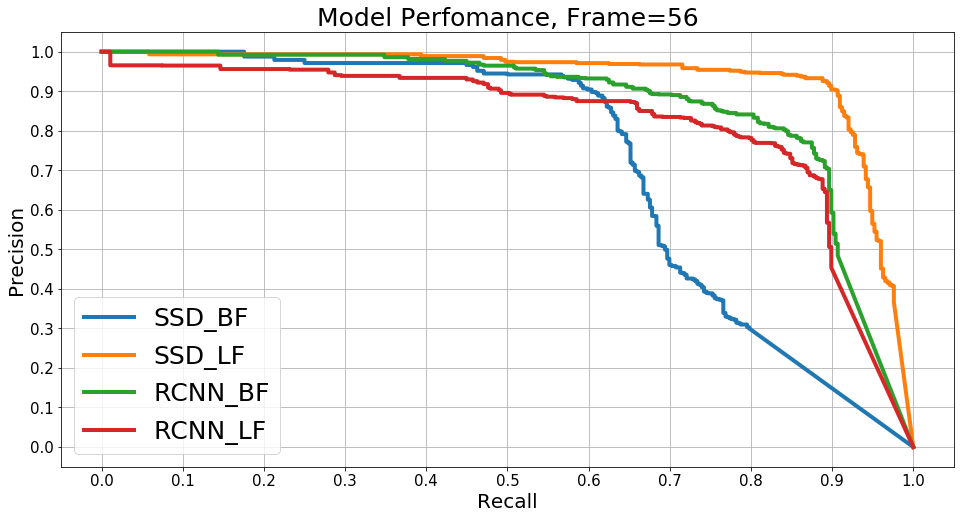

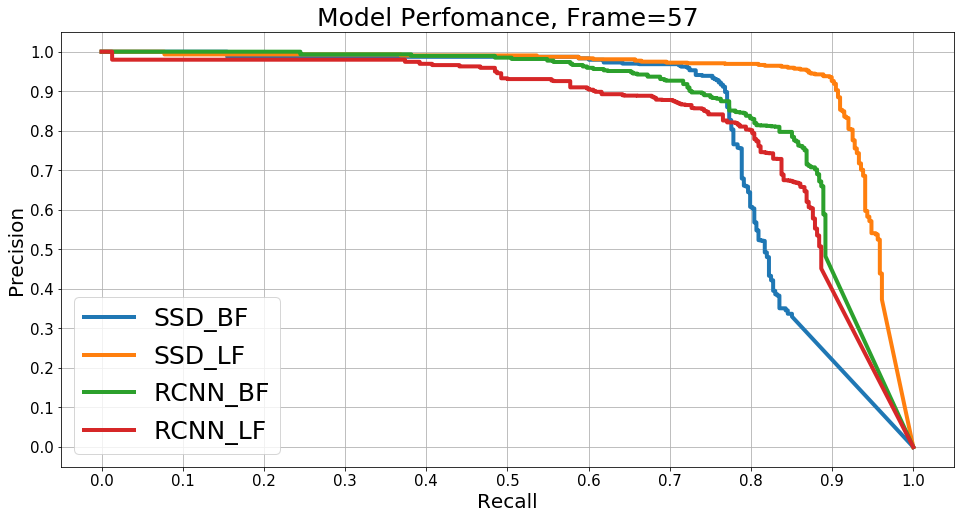

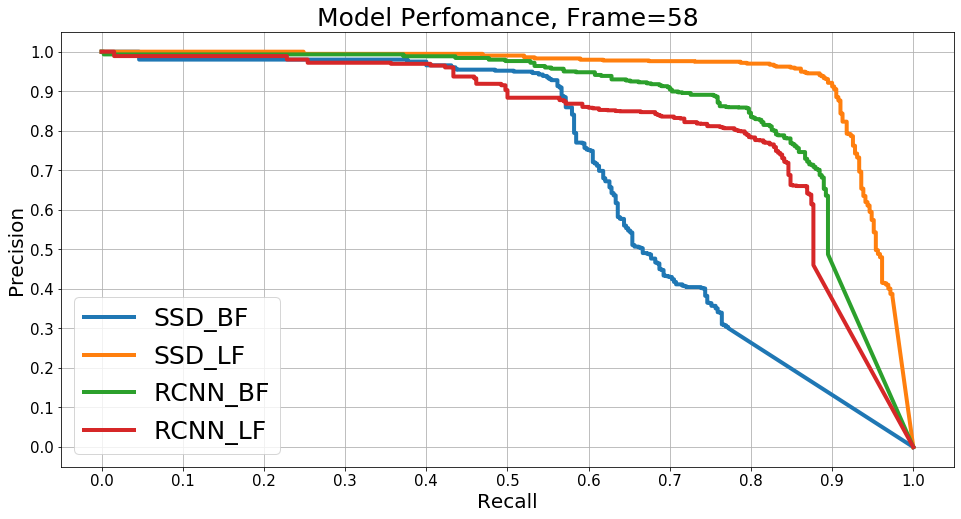

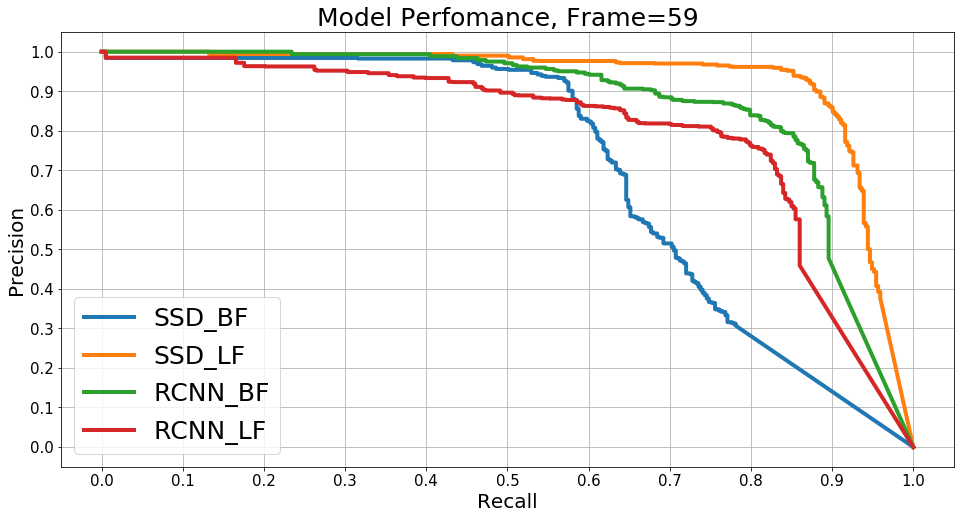

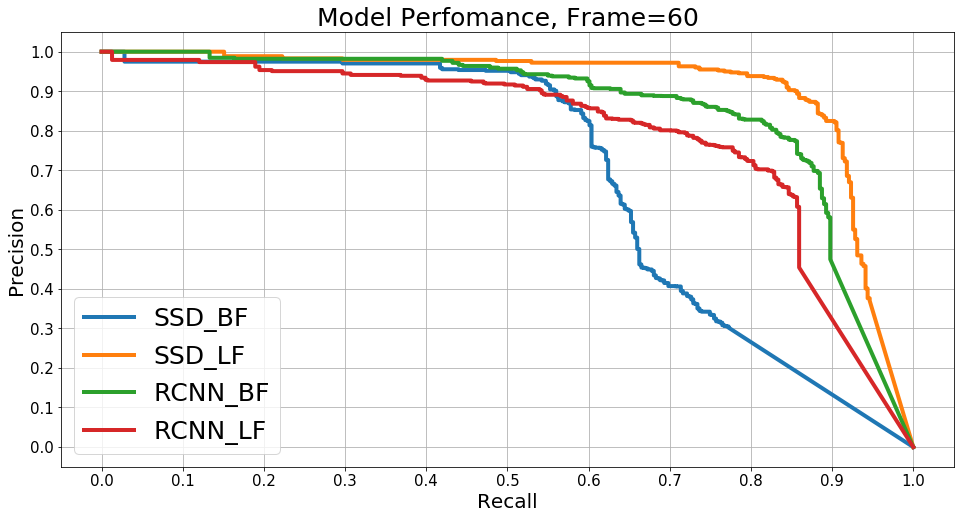

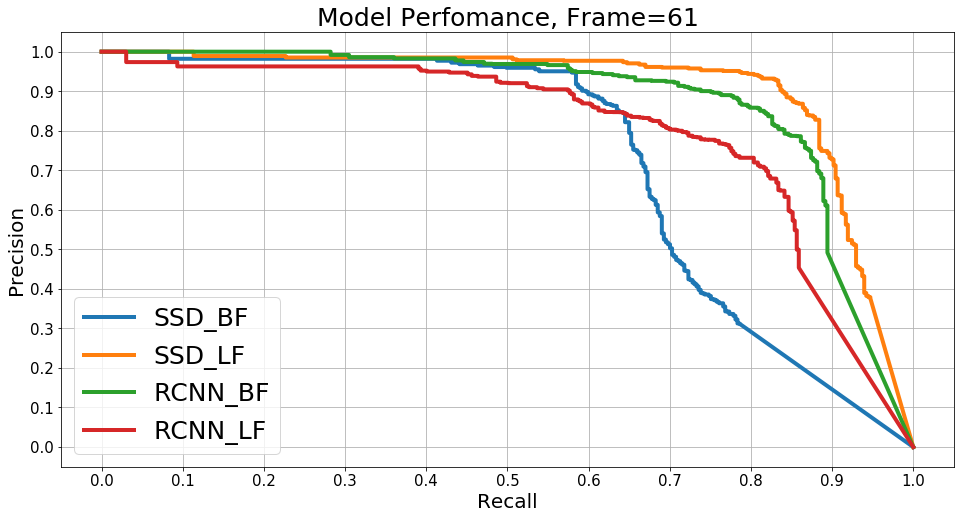

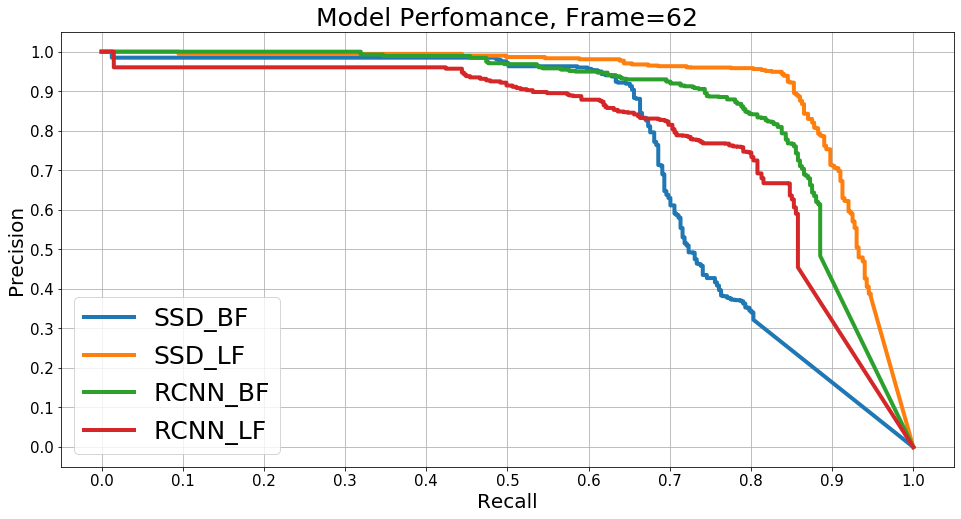

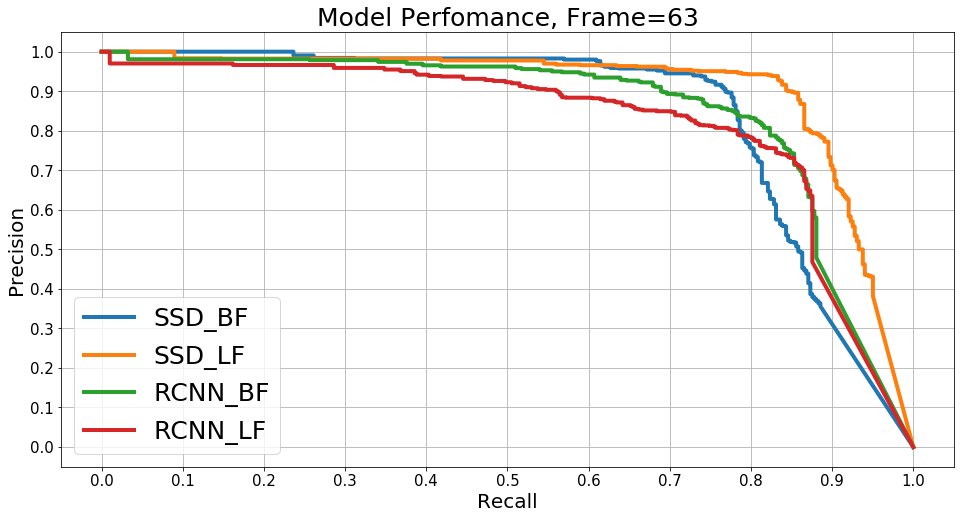

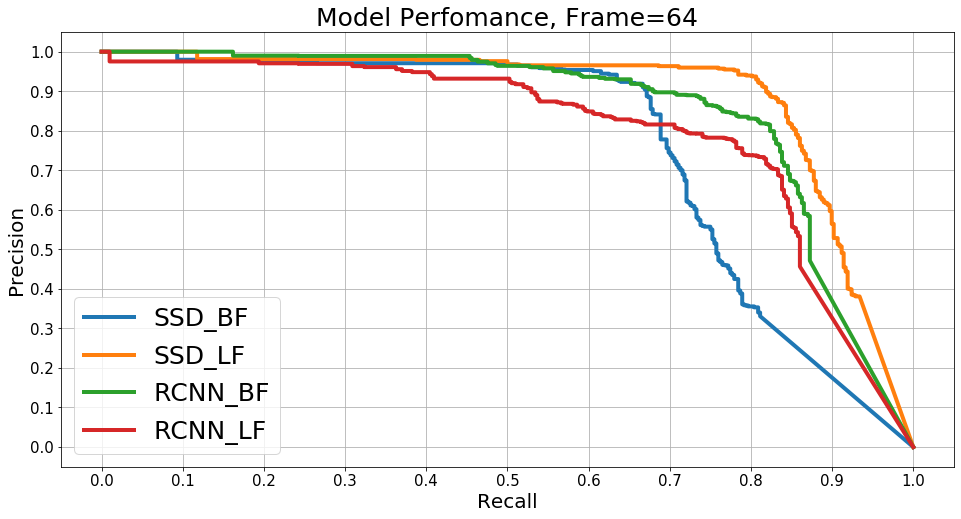

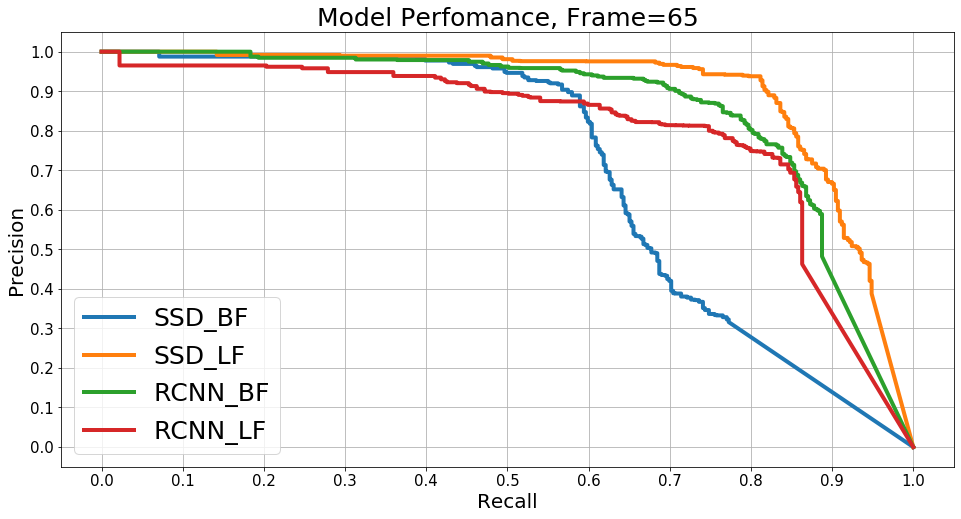

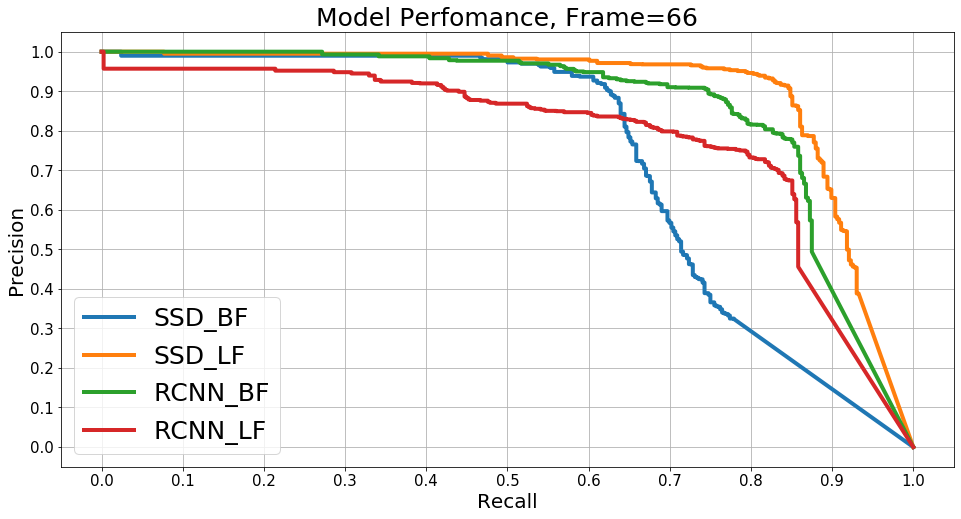

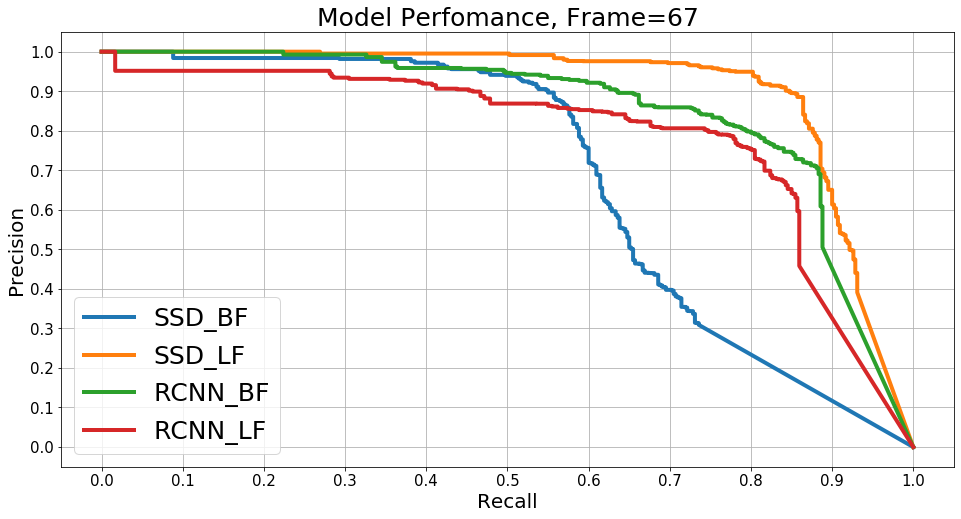

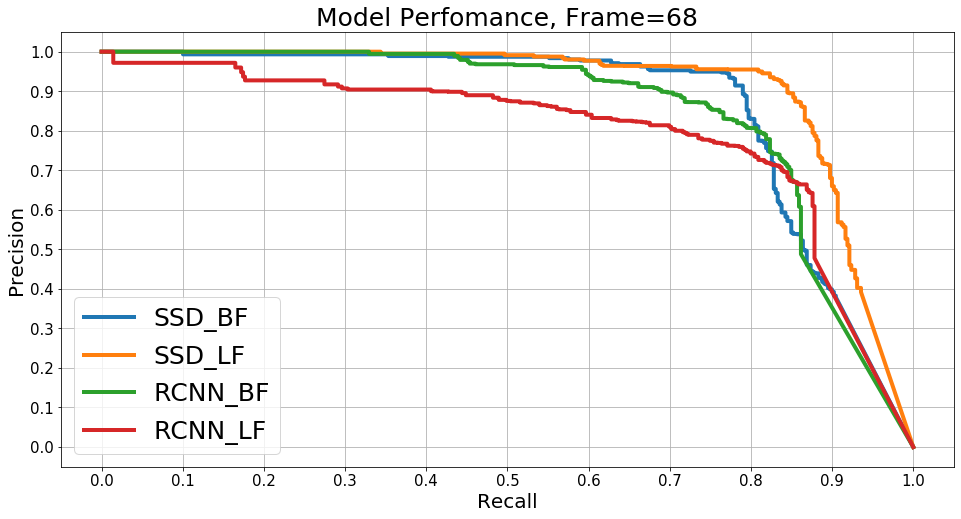

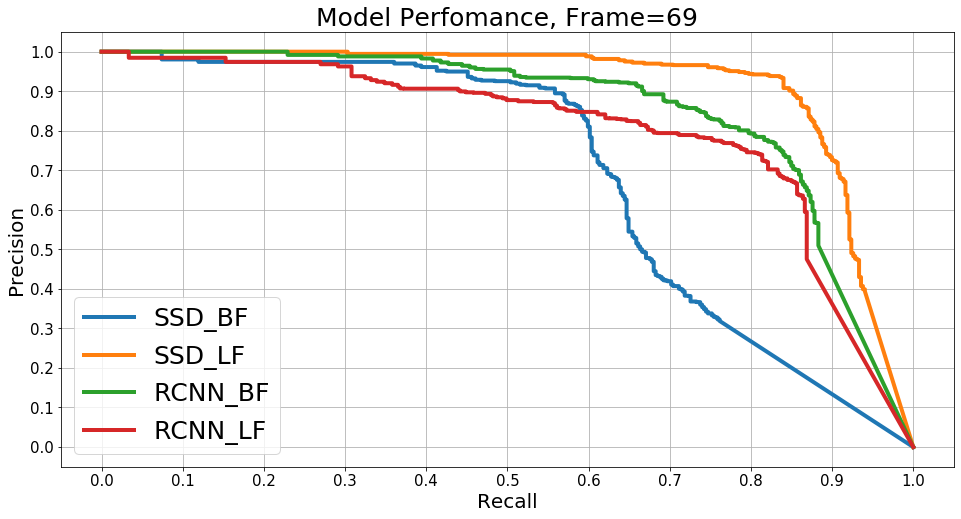

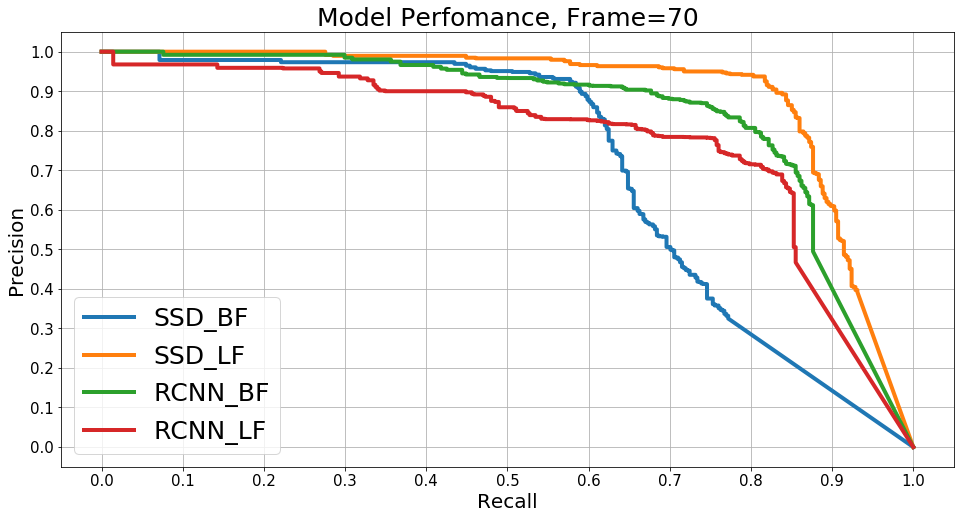

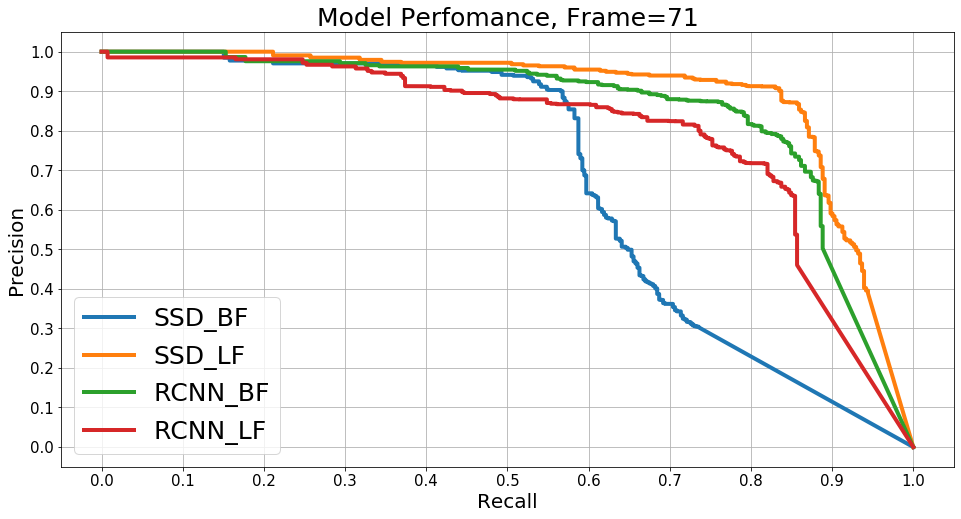

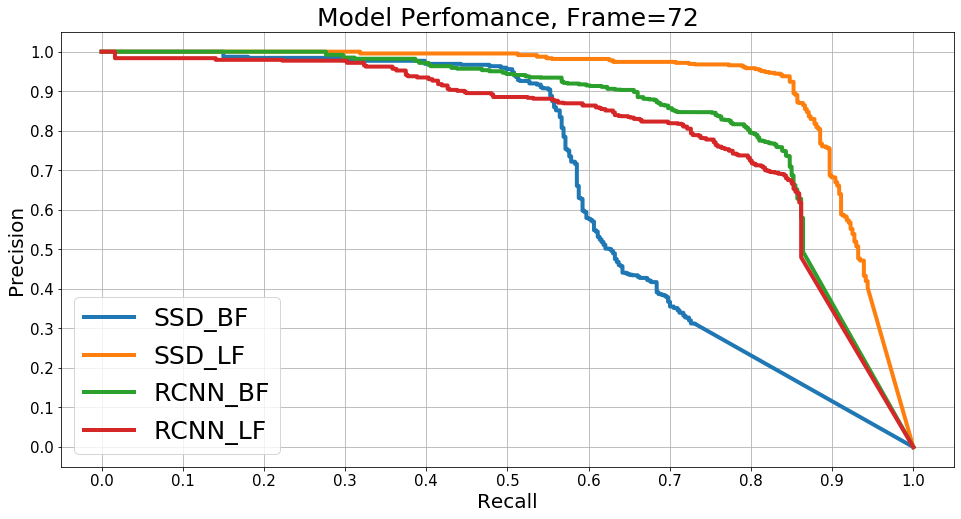

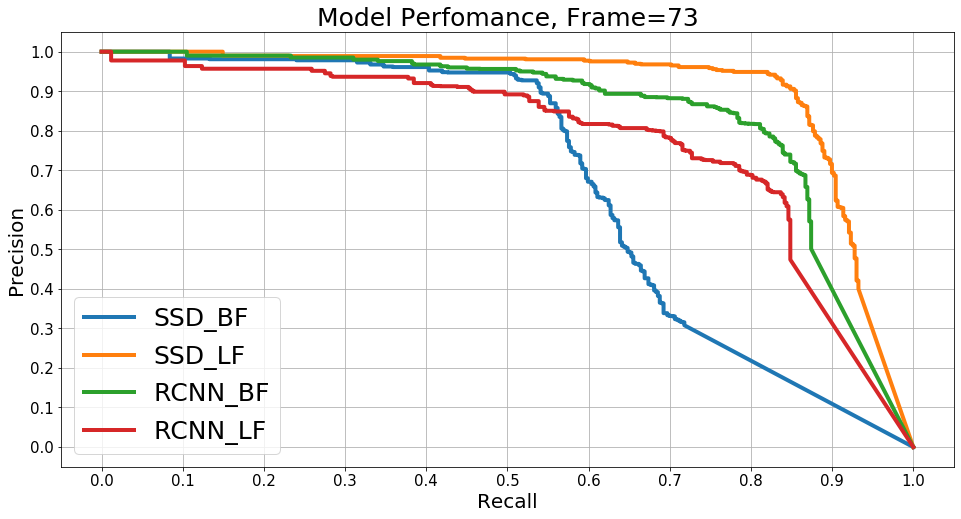

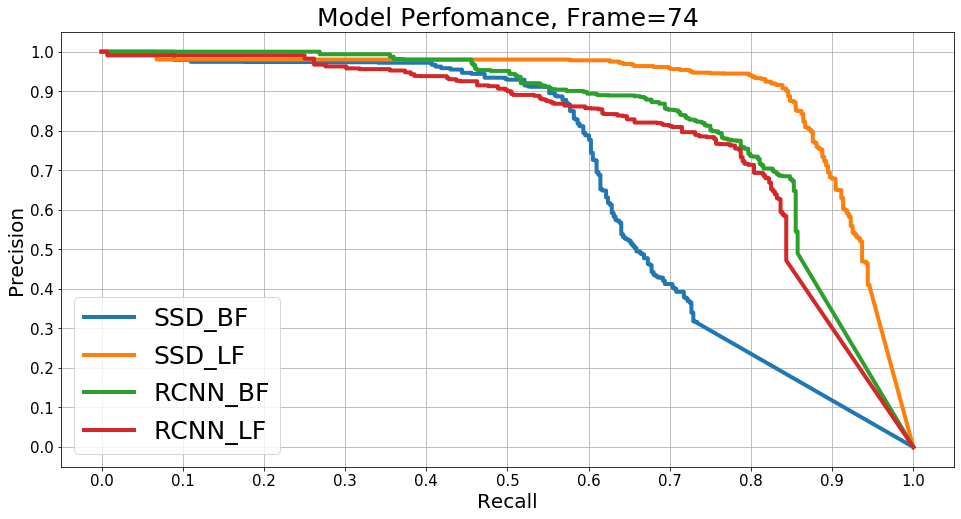

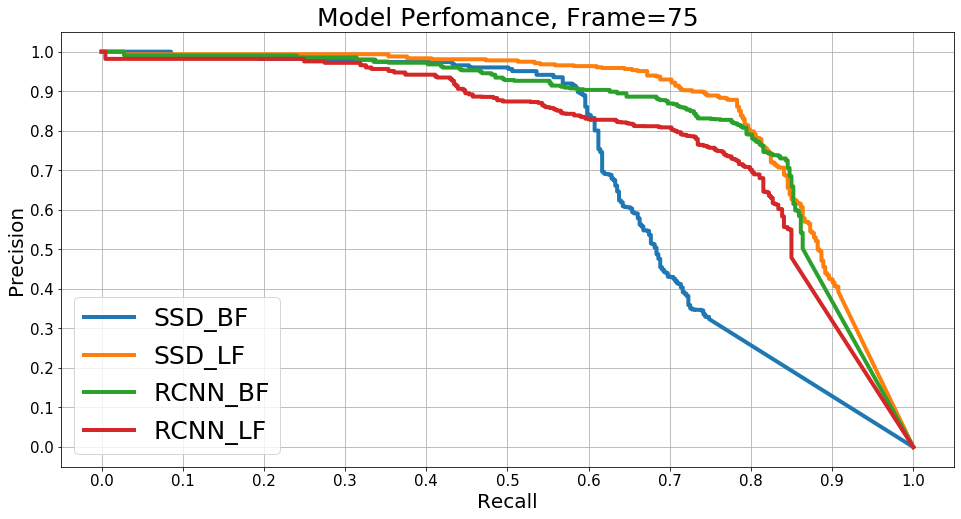

In [991]:
for i in range(75):
    plt.figure(figsize=(16,8))
    plt.title(f"Model Perfomance, Frame={i+1}", fontsize=25)
    for model, metrics in perfomances.items():
        plt.plot(metrics.get("recall")[i], metrics.get("precision")[i], label=model, linewidth=4)
    plt.xticks(np.linspace(0, 1, 11), fontsize=15)
    plt.yticks(np.linspace(0, 1, 11), fontsize=15)
    plt.xlabel("Recall", fontsize=20)
    plt.ylabel("Precision", fontsize=20)
    plt.grid()
    plt.legend(fontsize=25)
    plt.savefig(join(prec_path, f"curve_{i+1}.png"))

In [968]:
for model, metrics in perfomances.items():
    print(model)
    for recall, precision in zip(metrics.get("recall"), metrics.get("precision")):
        print(recall.shape)

SSD_BF
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
SSD_LF
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1002,)
(1

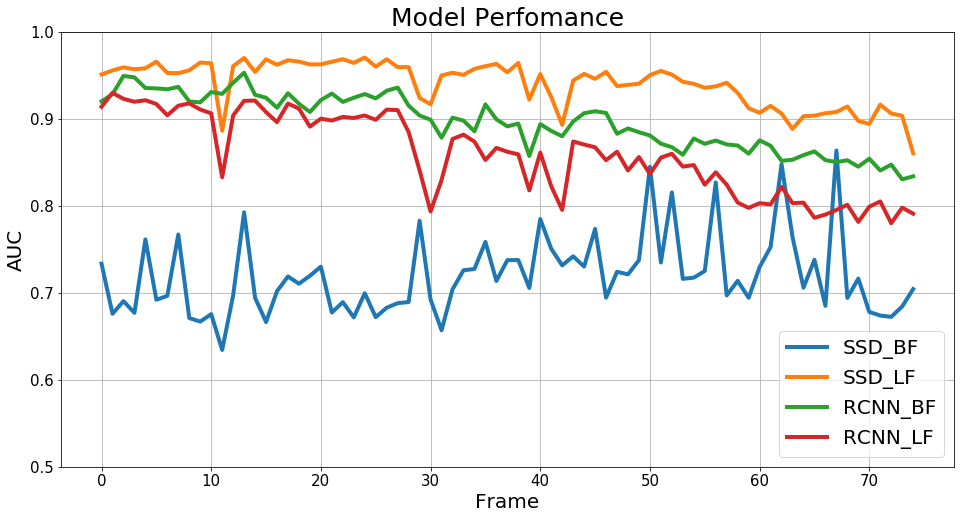

In [929]:
plt.figure(figsize=(16,8))
plt.title("Model Perfomance", fontsize=25)
for model, metrics in perfomances.items():
    plt.plot(metrics.get("auc"), linewidth=4, label=model)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim((0.5, 1))
plt.xlabel("Frame", fontsize=20)
plt.ylabel("AUC", fontsize=20)
plt.grid()
plt.legend(fontsize=20)
plt.show()

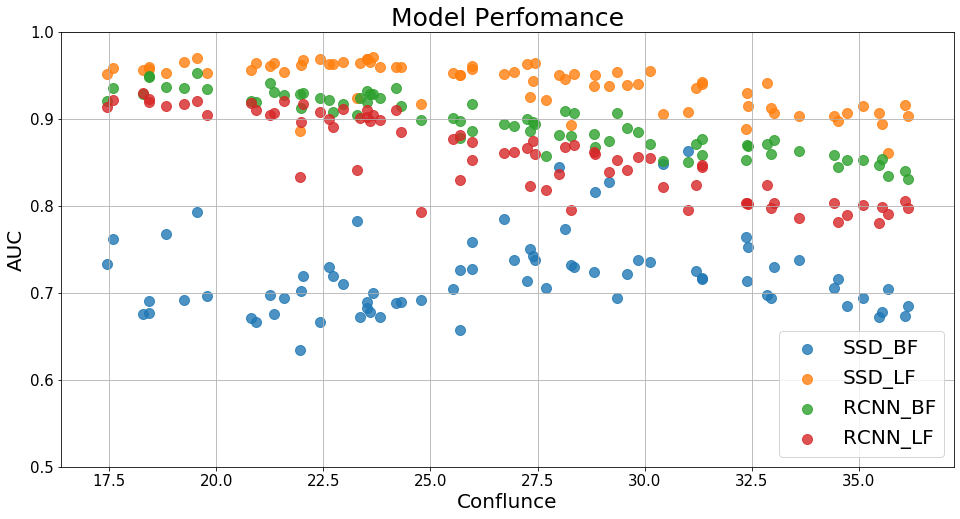

In [957]:
plt.figure(figsize=(16,8))
plt.title("Model Perfomance", fontsize=25)
for model, metric in perfomances.items():
    plt.scatter(confluencys.get("20200204_NRK_Hoechst_Pos7"), metric.get("auc"), s=100, label=model, alpha=0.8)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim((0.5, 1))
plt.xlabel("Conflunce", fontsize=20)
plt.ylabel("AUC", fontsize=20)
plt.legend(fontsize=20, loc="lower right")
plt.grid()
plt.show()

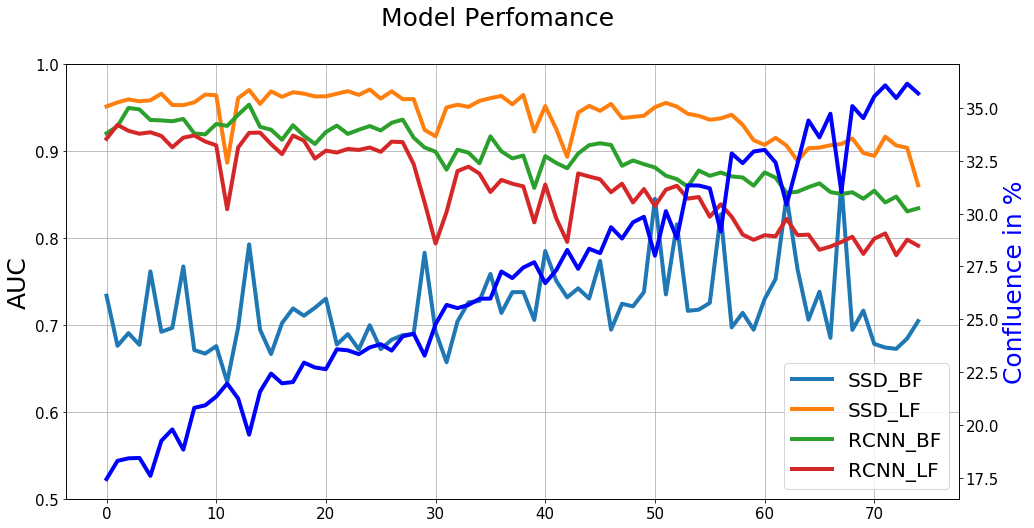

In [918]:
line_plot_two_axis([metrics.get("auc") for metrics in perfomances.values()],
                   [confluencys.get("20200204_NRK_Hoechst_Pos7")],
                  "Model Perfomance", "AUC", "Confluence in %",
                  labels1=[key for key in perfomances.keys()])

In [917]:
def line_plot_two_axis(y1, y2, title="", ylabel1="", ylabel2="", xlabel="", labels1=None):
    
    colors = list(mcolors.TABLEAU_COLORS.values())
    idx = 0
    
    fig, ax1 = plt.subplots()
    fig.suptitle(title, fontsize=25)
    fig.set_size_inches((16, 8))
    
    for data, label in zip(y1, labels1):
        ax1.plot(data, linewidth=4, color=colors[idx], label=label)
        idx += 1
    
    ax1.set_ylabel(ylabel1, fontsize=25)
    ax1.yaxis.label.set_color("black")
    ax1.tick_params(labelsize=15)
    ax1.set_xlabel(xlabel, fontsize=25)
    ax1.grid(axis="both")
    ax1.set_ylim((0.5, 1))
    
    ax2 = ax1.twinx()
    for data in y2:
        ax2.plot(data, linewidth=4, color="blue")
        idx += 1
    ax2.set_ylabel(ylabel2, fontsize=25)
    ax2.yaxis.label.set_color("blue")
    ax2.tick_params(labelsize=15)
    
    ax1.legend(loc="lower right", fontsize=20)
    plt.show()

In [400]:
aucs = []
mAPs = []

for annotation in tqdm(data, total=75):
    image = annotation.get("image")
    gt_bbox = annotation.get("bboxes")
    
    prediction = prediction_utils.run_inference_for_single_image(model, image)
    pred_boxes = prediction.get("detection_boxes")
    pred_scores = prediction.get("detection_scores")
    
    mAP, precisions, recalls, _ = statistics.compute_ap(pred_boxes, gt_bbox)
    
    aucs.append(auc(recalls, precisions))
    mAPs.append(mAP)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [04:27<00:00,  3.56s/it]


In [488]:
data = loader.tf_dataset_generator(DATA_PATH)
a = next(data)

In [492]:
data = loader.tf_dataset_generator(DATA_PATH)

image_means = []
image_stds = []
confluences = []
cells = []

for annotation in tqdm(data, total=75):
    image = annotation.get("image")
    
    number_of_boxes = annotation.get("bboxes").shape[0]
    cells.append(number_of_boxes)
    
    image_means.append(np.mean(image))
    image_stds.append(np.std(image))
    
    segmented = simple_segement(image)
    confl = get_confluency(segmented)
    confluences.append(confl)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 30.52it/s]


In [735]:
def line_plot_two_axis(y1, y2, title="", ylabel1="", ylabel2="", xlabel="Image"):
    fig, ax1 = plt.subplots()
    fig.suptitle(title, fontsize=25)
    fig.set_size_inches((15, 9))

    ax1.plot(y1, color="red", linewidth=4)
    ax1.set_ylabel(ylabel1, fontsize=25)
    ax1.yaxis.label.set_color("red")
    ax1.tick_params(labelsize=15)
    ax1.set_xlabel(xlabel, fontsize=25)
    
    ax2 = ax1.twinx()
    ax2.plot(y2, color="blue", linewidth=4)
    ax2.set_ylabel(ylabel2, fontsize=25)
    ax2.yaxis.label.set_color("blue")
    ax2.tick_params(labelsize=15)

    plt.show()

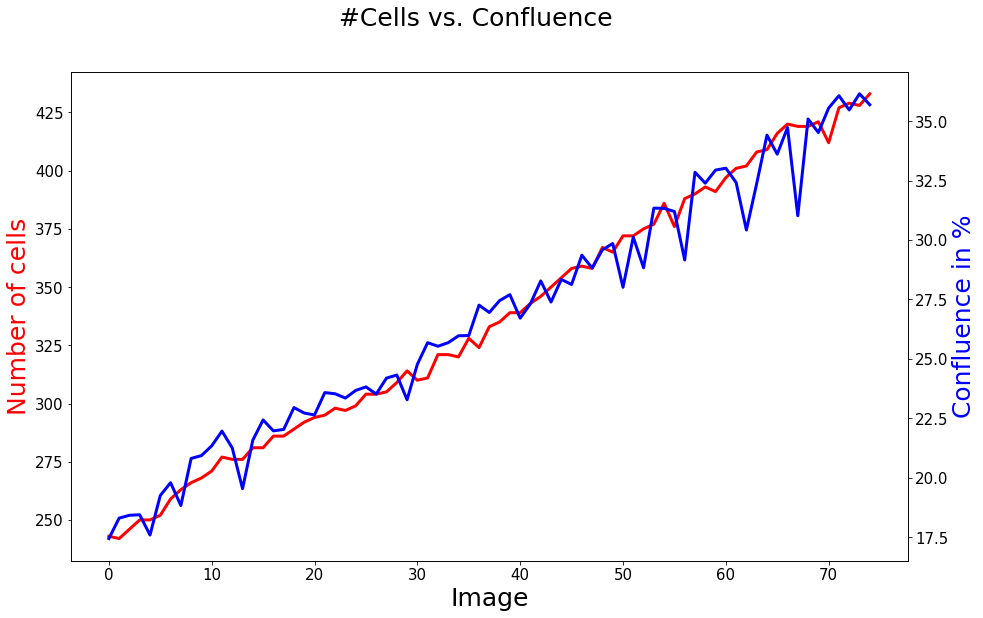

In [654]:
line_plot_two_axis(cells, confluencys, "#Cells vs. Confluence", "Number of cells", "Confluence in %")

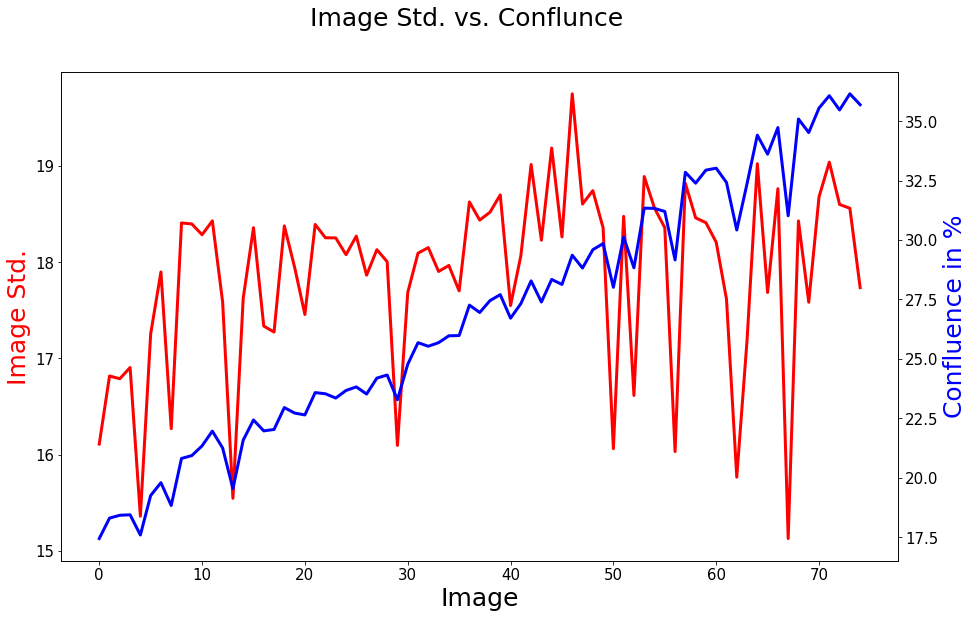

In [655]:
line_plot_two_axis(image_stds, confluencys, "Image Std. vs. Conflunce", "Image Std.", "Confluence in %")

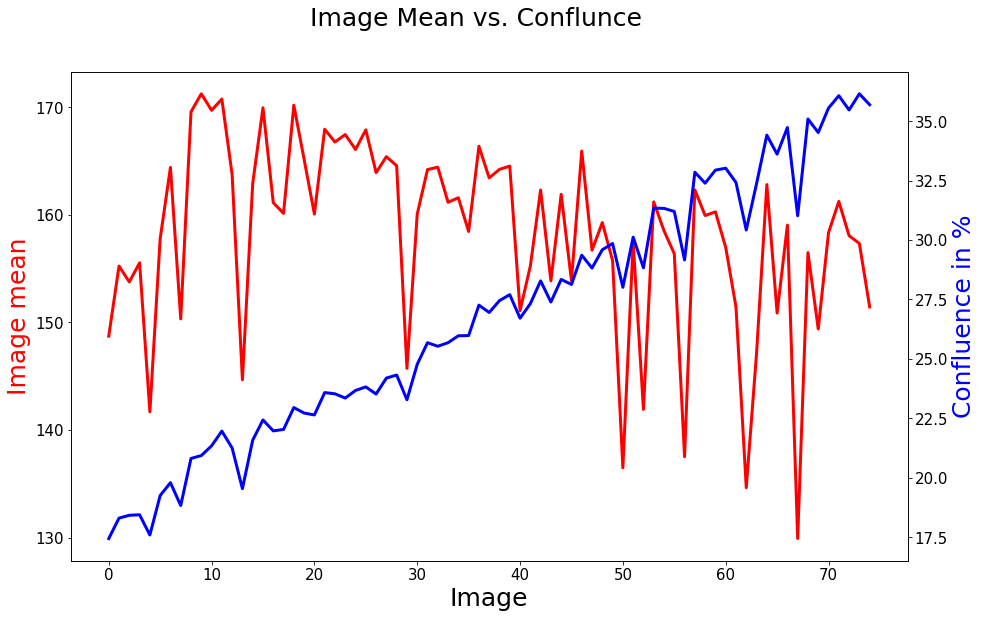

In [656]:
line_plot_two_axis(image_means, confluencys, "Image Mean vs. Conflunce", "Image mean", "Confluence in %")

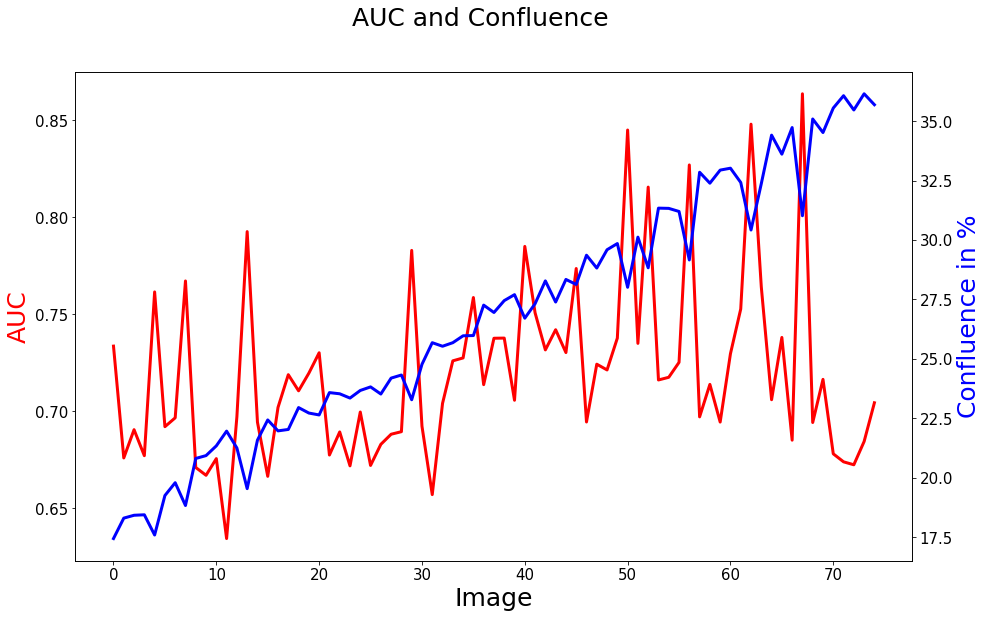

In [657]:
line_plot_two_axis(aucs, confluencys, "AUC and Confluence", "AUC", "Confluence in %")

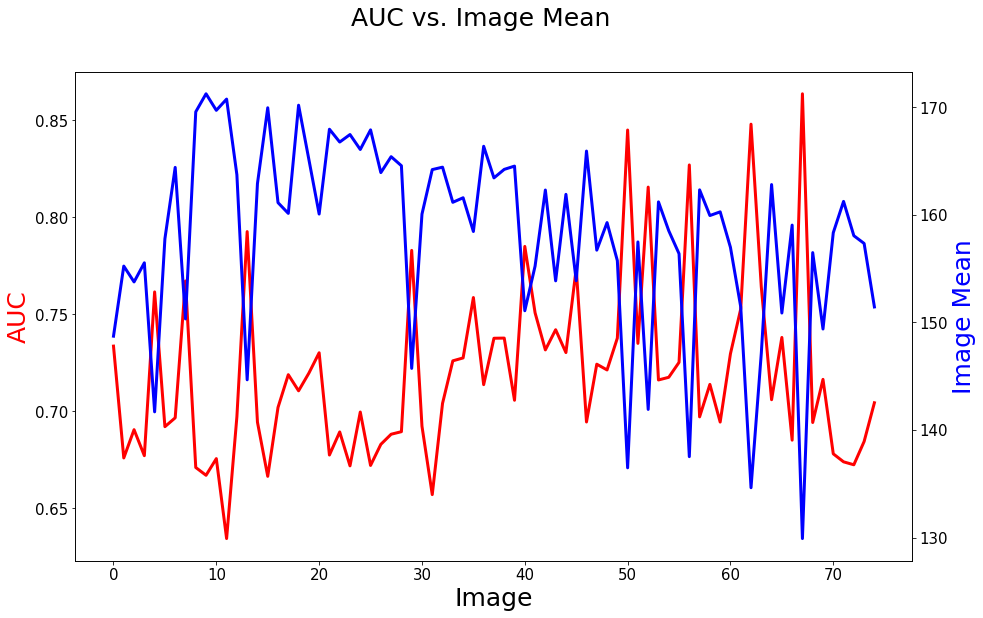

In [658]:
line_plot_two_axis(aucs, image_means, "AUC vs. Image Mean", "AUC", "Image Mean")

In [625]:
peaks = []
for i in range(1, len(confluencys)-1):
    before, actual, after = confluencys[i-1], confluencys[i], confluencys[i+1]
    
    if before*0.98 > actual < after*0.98:
        peaks.append(i)

In [660]:
def line_plot_two_axis(y1, y2, title="", ylabel1="", ylabel2="", xlabel="Image"):
    fig, ax1 = plt.subplots()
    fig.suptitle(title, fontsize=25)
    fig.set_size_inches((15, 9))

    ax1.plot(y1, color="red", linewidth=3)
    ax1.set_ylabel(ylabel1, fontsize=25)
    ax1.yaxis.label.set_color("red")
    ax1.tick_params(labelsize=15)
    ax1.set_xlabel(xlabel, fontsize=25)
    
    ax2 = ax1.twinx()
    ax2.plot(y2, color="blue", linewidth=5)
    ax2.set_ylabel(ylabel2, fontsize=25)
    ax2.yaxis.label.set_color("blue")
    ax2.tick_params(labelsize=15)
    
    _, _, ymin, ymax = ax2.yaxis.axes.axis()
    ax2.vlines(peaks, ymin, ymax, colors="blue", linestyles="dashed")
    
    plt.show()

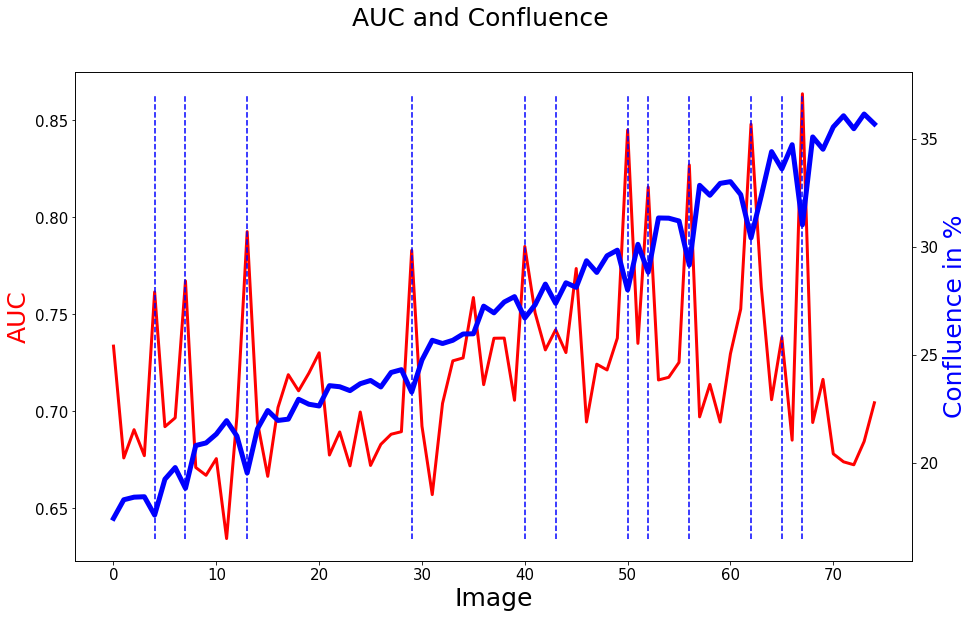

In [663]:
line_plot_two_axis(aucs, confluencys, "AUC and Confluence", "AUC", "Confluence in %")

# Predict on basic corrected

In [666]:
data = loader.tf_dataset_generator(DATA_PATH)
path = "D:\\Nabil_object_detection\\val\\20200204_NRK_Hoechst_Pos7\\10x_corrected"

In [668]:
corrected_aucs = []
corrected_mAPs = []

corrected_images = glob(join(path, "*.png"))

for i, annotation in enumerate(tqdm(data, total=75)):

    image = cv2.imread(corrected_images[i])
    
    gt_bbox = annotation.get("bboxes")
    
    prediction = prediction_utils.run_inference_for_single_image(model, image)
    pred_boxes = prediction.get("detection_boxes")
    pred_scores = prediction.get("detection_scores")
    
    mAP, precisions, recalls, _ = statistics.compute_ap(pred_boxes, gt_bbox)
    
    corrected_aucs.append(auc(recalls, precisions))
    corrected_mAPs.append(mAP)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [04:26<00:00,  3.55s/it]


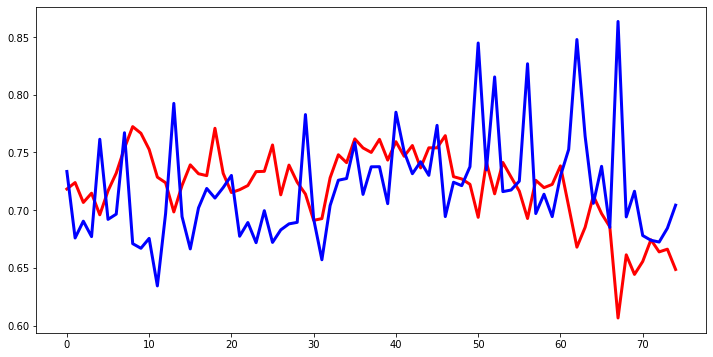

In [669]:
plt.figure(figsize=(12,6))
plt.plot(corrected_aucs, "red", linewidth=3)
plt.plot(aucs, color="blue", linewidth=3)
plt.show()

In [684]:
from scipy.interpolate import make_interp_spline, BSpline

In [701]:
def interpolate(data):
    x = list(range(len(data)))

    x_new = np.linspace(0, 12, 75)

    a_BSpline = make_interp_spline(x, data)
    return a_BSpline(x_new)

In [702]:
aucs_inter = interpolate(aucs)
corrected_inter = interpolate(corrected_aucs)

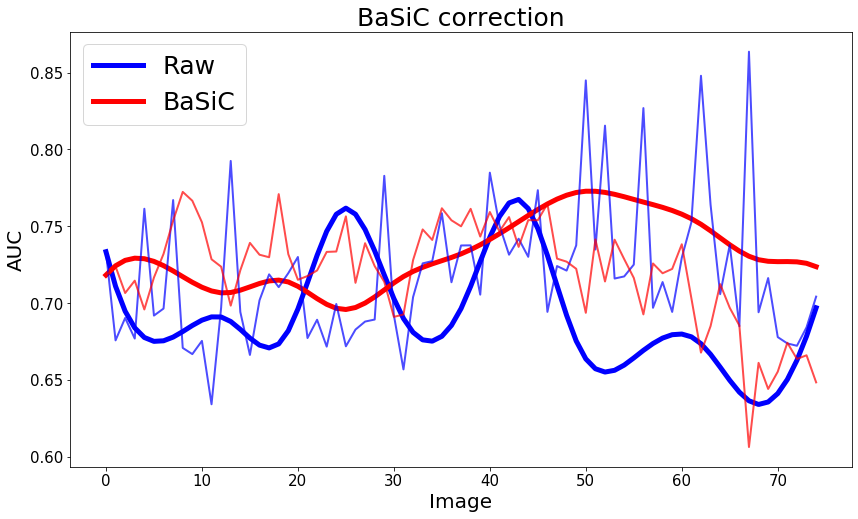

In [703]:
plt.figure(figsize=(14, 8))
plt.title("BaSiC correction", fontsize=25)
plt.plot(aucs_inter, color="blue", linewidth=5, label="Raw")
plt.plot(corrected_inter, color="red", linewidth=5, label="BaSiC")
plt.plot(aucs, color="blue", linewidth=2, alpha=0.7)
plt.plot(corrected_aucs, color="red", linewidth=2, alpha=0.7)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Image", fontsize=20)
plt.ylabel("AUC", fontsize=20)

plt.legend(loc="upper left", fontsize=25)
plt.show()